<a href="https://colab.research.google.com/github/KLeeDE/PUS2020_KLee/blob/master/Project/20201214_Wilimington_oneper_blockg_ml_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SPPA667 Final Project: Plots and Visualization**

Written by: @KLeeDE

Date: 12/14/2020

**Topic**: An Analysis on Flood Risk and Socio-Economic and Demographic Status

**Research Area**: Wilmington, Delaware


**Available data**

Wilmington data

1. Flood Depth Grid (2014/Raster/Federal Emergency Management Agency (FEMA)
*  CstDpthxxxpct: Coastal flood depth for the xxx percent
annual chance flood event. This raster is
required to be produced for coastal Flood
Risk Projects. [Feet]
*   CstDpth_01pct : Raster dataset of flood depth for a coastal 1% event. (1-percent-annualchance) [Feet]
*   Depth_01pct : Raster dataset of flood depth for a 1% event [Feet]

2. Census data Block Group (2010/CSV/U.S.Census Bureau)

3. Socioeconomic and Demographic (SED) data (2014 (ACS5) / Shapefile / U.S. Census Bureau)




**Additional rastar data description**

County
*   10001C: Kent County
*   10003C: New Castle County
*   10005C: Sussex County

Flood hazard is defined by a relation between depth of flooding and the annual chance of inundation greater than that depth.

Depth grid is defined by **the percent annual chance floods**. This is usually only **the 1% annual chance flood**.

#Feedback

* your binary target variable, can you remind me if it corresponds to a probability of fload greater than some threshold? what is the threshold? 50%?


* can you define how you standardize your data? I do not understand why you are retaining the standardized and non standardized variables: they are the same variable transformed linearly no? then arent you basically using the same data twice?


* you went very quickly through the correlation matrix, but if you look at it you will find the proof of the comment i made before ^^^ - make sure you discuss the matrix and draw insight from it in your report!


* so your. model is now underperforming: the performance of the RF decreases from 80% to 50% on the testing data. But this is a binary variable that you are trying to predict... what would the performance be if you were guessing randomely? how does it compare with your model performance? while earlier you were overfitting. now you are underfitting! consider making your RF model a bit more complex


* then because your model is NOT performing well... you cannot do a feature analysis. the feature importance analysis asks what is the model using to make a prediction. which is interesting if the prediction is good but uninteresting if it is a bad prediction... also you still have the problem that your variables are identical by pair (the standardized and not standardized version of them)


# Original Plot

In [4]:
# -- mount drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# -- install geospatial packages
!sudo apt install libspatialindex-dev
!pip install rtree
!pip install geopandas
!pip install censusdata

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [6]:
import time
import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdal
from gdalconst import *
from shapely.geometry import Point
from collections import Counter
import censusdata
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,10)

## Flood Depth data

In [7]:
# data: 1% depth / DE / coastal area / New Castle (10003C)
fname3C_Cst_Dpth01pct = "/content/drive/My Drive/flooding/data/FEMA_Coastal_GeoTIFFs/New  Castle/FRD_10003C_Coastal_GeoTIFFS_20140516/10003C_Coastal_CstDpth01pct.tif"
# read in a raster data
rast3C_Cst_Dpth01pct = gdal.Open(fname3C_Cst_Dpth01pct, GA_ReadOnly)
# extract raster to array
samp=100
arr3C_Cst_Dpth01pct = rast3C_Cst_Dpth01pct.ReadAsArray()[::samp, ::samp]
arr3C_Cst_Dpth01pct = arr3C_Cst_Dpth01pct.clip(0,10)
#arr3C_Cst_Dpth01pct = rast3C_Cst_Dpth01pct.ReadAsArray()

In [8]:
print(arr3C_Cst_Dpth01pct.shape)

(183, 102)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:488: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)


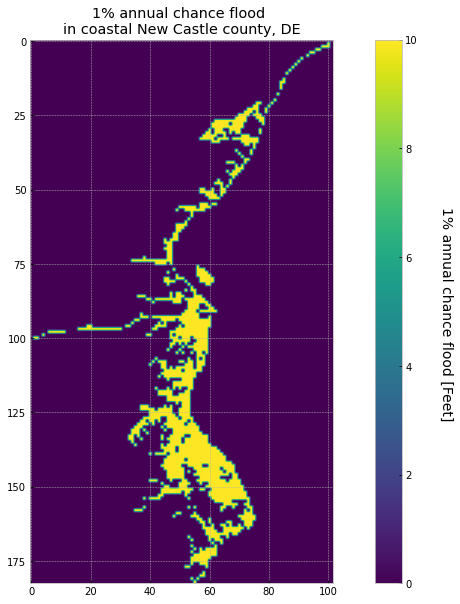

In [71]:
#  plot raster : 1% depth / DE / coastal area  
fig_raster, ax = plt.subplots()
im = ax.imshow(arr3C_Cst_Dpth01pct)

ax.imshow(rast3C_Cst_Dpth01pct.ReadAsArray()[::samp, ::samp])
ax.set_title("1% annual chance flood \nin coastal New Castle county, DE")
fig_raster.colorbar(im)
fig_raster.text(0.85, 0.5, "1% annual chance flood [Feet]", va="center", ha="center", rotation=-90, fontsize=14)
plt.show()

**Fig1. Flood Depth Grid** Subtitle is the one percent annual chance flood in coastal New Castle County (Unit: Feet). Flood hazard is defined by a relation between depth of flooding and the annual chance of inundation greater than that depth. Depth grid is defined by the percent annual chance floods. This is usually only the 1% annual chance flood.This figure is  based on the raster data from the Federal Emergency Management Agency (FEMA) in 2014, which is the most recent available data in Delaware. 

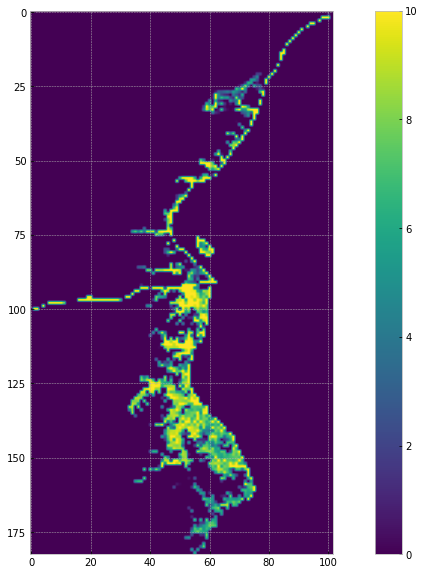

In [10]:
 # set Latitude/Longitude

# read in the meta data file as list of strings:
mname3c = "/content/drive/My Drive/flooding/data/FEMA_Coastal_GeoTIFFs/New  Castle/FRD_10003C_Coastal_GeoTIFFS_20140516/10003C_Coastal_CstDpth01pct.tif.xml"
fopen = open(mname3c, "r")
lines = [i for i in fopen]
fopen.close()

# get lat lon meta data
for line in lines:
  if "<westBL Sync=\"TRUE\">" in line:
    westBL = float(line.split("<westBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<eastBL Sync=\"TRUE\">" in line:
    eastBL = float(line.split("<eastBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<northBL Sync=\"TRUE\">" in line:
    northBL = float(line.split("<northBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<southBL Sync=\"TRUE\">" in line:
    southBL = float(line.split("<southBL Sync=\"TRUE\">")[2].split("<")[0])

# get number of rows and cols
nrows3c, ncols3c = arr3C_Cst_Dpth01pct.shape

# create lat and lon arrays
# define upperleft and resolution
ul_r = northBL
ul_c = westBL
dr   = (northBL - southBL) / nrows3c
dc   = (eastBL - westBL) / ncols3c

# generate a grid of row and col indices
cols3c, rows3c = np.meshgrid(np.arange(ncols3c), np.arange(nrows3c))

lat_grid_3c = ul_r - rows3c * dr
lon_grid_3c = ul_c + cols3c * dc

# plt.imshow(lat_grid_3c)
# plt.colorbar()
# plt.hist(np.log10(arr1C_Cst_Dpth01pct[arr1C_Cst_Dpth01pct > 0]))

dep_grid_3c = arr3C_Cst_Dpth01pct
ax = plt.imshow(dep_grid_3c)
plt.colorbar()

# plt.hist(dep_grid_3c[dep_grid_3c > -1e38].flatten())

## Block Group shapefile

In [11]:
def label_plot(plot_axis, title, x_axis_label, y_axis_label, title_weight="bold", title_size=16, axis_weight="bold", axis_size=14 ):
  plot_axis.set_title(title, weight=title_weight, size=title_size)
  plot_axis.set_xlabel(x_axis_label, weight=axis_weight, size=axis_size)
  plot_axis.set_ylabel(y_axis_label, weight=axis_weight, size=axis_size)

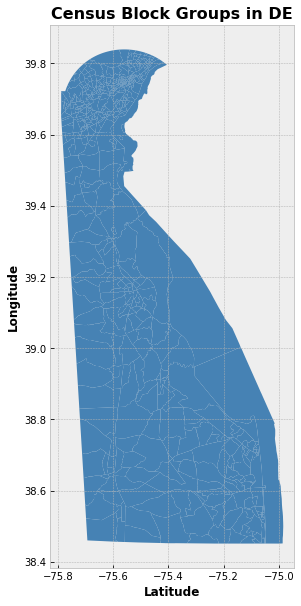

In [12]:
# load the census block group (2016)
cblkgname = "/content/drive/My Drive/flooding/data/censusblock/tl_2016_10_bg/tl_2016_10_bg.shp"
decblkg_2016 = gp.read_file(cblkgname)

# figure
fig_cblockg16, ax = plt.subplots()
decblkg_2016.plot(color="steelblue", ax=ax)
label_plot(ax, "Census Block Groups in DE", "Latitude", "Longitude", axis_size=12, title_size=16)
fig_cblockg16.savefig("/content/drive/My Drive/flooding/figure/sppa667")

In [13]:
decblkg_2016

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,10,003,014705,2,100030147052,Block Group 2,G5030,S,2747580,0,+39.6565693,-075.7179591,"POLYGON ((-75.73365 39.65395, -75.73347 39.653..."
1,10,005,990000,0,100059900000,Block Group 0,G5030,S,0,534627888,+38.8648060,-075.2250098,"POLYGON ((-75.30529 38.94809, -75.30454 38.948..."
2,10,005,051007,1,100050510071,Block Group 1,G5030,S,3777749,1042552,+38.6967796,-075.1040689,"POLYGON ((-75.11929 38.69613, -75.11914 38.697..."
3,10,005,051400,2,100050514002,Block Group 2,G5030,S,21467604,0,+38.4626429,-075.2782798,"POLYGON ((-75.33073 38.45312, -75.33011 38.454..."
4,10,005,051500,3,100050515003,Block Group 3,G5030,S,8337616,0,+38.5427423,-075.2461144,"POLYGON ((-75.27591 38.56353, -75.27587 38.563..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,10,003,014907,3,100030149073,Block Group 3,G5030,S,315556,0,+39.6422492,-075.6601384,"POLYGON ((-75.66419 39.64344, -75.66281 39.644..."
570,10,003,016302,2,100030163022,Block Group 2,G5030,S,1063837,0,+39.6410513,-075.6415809,"POLYGON ((-75.65325 39.63536, -75.65324 39.635..."
571,10,003,016904,2,100030169042,Block Group 2,G5030,S,93018625,7441873,+39.3744719,-075.5757732,"POLYGON ((-75.66163 39.37267, -75.66151 39.372..."
572,10,003,001500,1,100030015001,Block Group 1,G5030,S,198949,23880,+39.7525587,-075.5599421,"POLYGON ((-75.56277 39.75075, -75.56241 39.751..."


**Fig 2. Census Block Groups** Subtitle is the census block groups in New Castle County. This figure is based on 2016 shapefile. 

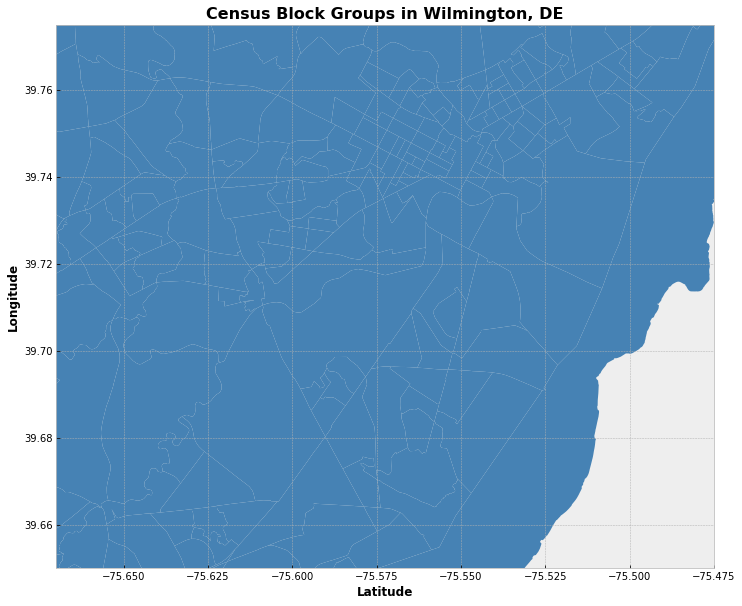

In [14]:
decblkg_2016_copy = decblkg_2016.copy()

fig_cblockg_wm, ax = plt.subplots()
decblkg_2016_copy.plot(color="steelblue", ax=ax)
ax.set_xlim(-75.67, -75.475)
ax.set_ylim(39.65, 39.775)
label_plot(ax, "Census Block Groups in Wilmington, DE", "Latitude", "Longitude", axis_size=12, title_size=16)

fig_cblockg_wm.savefig("/content/drive/My Drive/flooding/figure/sppa667")

In [15]:
decblkg_2016_copy['AWATER'].min(), decblkg_2016_copy['AWATER'].max()

(0, 534627888)

**Fig 2. Census Block Groups**
Subtitle is the census block groups in New Castle County. This figure is based on 2016 shapefile.The original shapefile includes water area, no land area, where they are generally in territorial seas, coastal water, and Great Lakes water areas.

## Socioeconomic demographic (SED) data 

In [16]:
# -- lablel plot
def label_plot(plot_axis, title, x_axis_label, y_axis_label, title_weight="bold", title_size=16, axis_weight="bold", axis_size=14 ):
  plot_axis.set_title(title, weight=title_weight, size=title_size)
  plot_axis.set_xlabel(x_axis_label, weight=axis_weight, size=axis_size)
  plot_axis.set_ylabel(y_axis_label, weight=axis_weight, size=axis_size)

#--Getting standardized values
#def standardize(dataframe, original_column_name:str, intended_column_name:str):
  #values = dataframe[original_column_name]
  #values_mean = values.mean()
  #values_stdev = values.std()
  #standardized_values = []
  #for i in values:
    #standardized_values.append((i-values_mean)/values_stdev)
  #dataframe[intended_column_name] = standardized_values

In [17]:
# -- Median household income by census block group : New Castle
censusdata.censustable('acs5', 2014, 'B19049')
censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2014)
censusdata.geographies(censusdata.censusgeo([('state', '10'), ('county', '*')]), 'acs5', 2014)
income_cblkg = censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', '003'), ('block group', '*')]), ["B19049_001E"])
nc_income_cblkg  = pd.concat([censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', i), ('block group', '*')]), ["B19049_001E"]) for i in ["003"]])
nc_income_cblkg['mincome'] = nc_income_cblkg["B19049_001E"].clip(0,1e9).dropna() 
#--Getting standardized values
#standardize(nc_income_cblkg, "mincome", "mincome_st")
nc_income_cblkg = nc_income_cblkg[["mincome"]]#, "mincome_st"]]
#--data description
print("Median household income in New Castle County, DE")
print(nc_income_cblkg.describe())

Median household income in New Castle County, DE
             mincome
count     368.000000
mean    67356.024457
std     33026.081728
min         0.000000
25%     45678.750000
50%     61144.000000
75%     83391.000000
max    209250.000000


In [18]:
# -- Racial factors (White alone / Total) by census block group
censusdata.censustable('acs5', 2014, 'B02001')
censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2014)
censusdata.geographies(censusdata.censusgeo([('state', '10'), ('county', '*')]), 'acs5', 2014)
race_cblkg = censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', '003'), ('block group', '*')]), ["B02001_001E", "B02001_002E"])
nc_race_cblkg  = pd.concat([censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', i), ('block group', '*')]), ["B02001_001E", "B02001_002E"]) for i in ["003"]])
nc_race_cblkg['per_white'] = nc_race_cblkg["B02001_002E"] / nc_race_cblkg["B02001_001E"] * 100
nc_race_cblkg['per_nonwhite'] = (nc_race_cblkg["B02001_001E"] - nc_race_cblkg["B02001_002E"])/nc_race_cblkg["B02001_001E"] *100
nc_race_cblkg = nc_race_cblkg[['per_white', 'per_nonwhite']].clip(0,1e9).dropna()
#--Getting standardized values
#standardize(nc_race_cblkg, "per_nonwhite", "per_nonwhite_st")
nc_race_cblkg = nc_race_cblkg[["per_nonwhite"]]#, "per_nonwhite_st"]]
#--data description
print("Percent of Not White in New Castle County, DE")
print(nc_race_cblkg.describe())

Percent of Not White in New Castle County, DE
       per_nonwhite
count    366.000000
mean      33.694627
std       27.510316
min        0.000000
25%       11.243796
50%       24.158250
75%       50.777329
max      100.000000


In [19]:
# Poverty rate by census block group
censusdata.censustable('acs5', 2014, 'B17010')
censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2014)
censusdata.geographies(censusdata.censusgeo([('state', '10'), ('county', '*')]), 'acs5', 2014)
poverty_cblkg = censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', '003'), ('block group', '*')]), ["B17010_001E", "B17010_002E"])
nc_poverty_cblkg  = pd.concat([censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', i), ('block group', '*')]), ["B17010_001E", "B17010_002E"]) for i in ["003"]])
nc_poverty_cblkg['per_below_povlev'] = nc_poverty_cblkg["B17010_002E"] / nc_poverty_cblkg["B17010_001E"] * 100
nc_poverty_cblkg = nc_poverty_cblkg[['per_below_povlev']].clip(0,1e9).dropna()
#--Getting standardized values
#standardize(nc_poverty_cblkg, 'per_below_povlev', 'per_below_povlev_st')
nc_poverty_cblkg = nc_poverty_cblkg[["per_below_povlev"]]#, "per_below_povlev_st"]]
#--data description
print("Percent of People Under Poverty Line in New Castle County, DE")
print(nc_poverty_cblkg.describe())

Percent of People Under Poverty Line in New Castle County, DE
       per_below_povlev
count        365.000000
mean           9.214050
std           13.249521
min            0.000000
25%            0.000000
50%            3.773585
75%           12.932790
max           82.666667


In [20]:
# (New) Total population by census block group
# Total Population in Occupied Housing units by Tenure (B25008)
censusdata.censustable('acs5', 2014, 'B25008')
censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2014)
censusdata.geographies(censusdata.censusgeo([('state', '10'), ('county', '*')]), 'acs5', 2014)
censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', '003'), ('block group', '*')]), ["B25008_001E"])
nc_pop_cblkg  = pd.concat([censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', i), ('block group', '*')]), ["B25008_001E"]) for i in ["003"]])
nc_pop_cblkg['population'] = nc_pop_cblkg["B25008_001E"] 
nc_pop_cblkg = nc_pop_cblkg[["population"]]
#--data description
print("Number of total population in occupied housing units by tenure in New Castle County, DE")
print(nc_pop_cblkg.describe())

Number of total population in occupied housing units by tenure in New Castle County, DE
        population
count   368.000000
mean   1437.451087
std     905.320121
min       0.000000
25%     858.750000
50%    1152.000000
75%    1835.750000
max    6553.000000


In [21]:
# (New) Highschool degree by census block group
# School Enrollment by Level of School for the Population 3 Years and Over','label': 'Not enrolled in school'
censusdata.censustable('acs5', 2014, 'B14007')
censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2014)
censusdata.geographies(censusdata.censusgeo([('state', '10'), ('county', '*')]), 'acs5', 2014)
censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', '003'), ('block group', '*')]), ["B14007_019E"])
nc_school_cblkg  = pd.concat([censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', i), ('block group', '*')]), ["B14007_019E"]) for i in ["003"]])
nc_school_cblkg['no_school'] = nc_school_cblkg["B14007_019E"] 
nc_school_cblkg = nc_school_cblkg[["no_school"]]
#--Getting standardized values
#standardize(nc_poverty_cblkg, 'per_below_povlev', 'per_below_povlev_st')
nc_school_cblkg = nc_school_cblkg[["no_school"]]#, "per_below_povlev_st"]]
#--data description
print("Not enrolled in School Enrollment by Level of School for the Population 3 Years and Over in New Castle County, DE")
print(nc_school_cblkg.describe())

Not enrolled in School Enrollment by Level of School for the Population 3 Years and Over in New Castle County, DE
         no_school
count   368.000000
mean   1026.432065
std     596.796311
min       0.000000
25%     626.250000
50%     842.500000
75%    1263.750000
max    4066.000000


A vulnerable person can be defined as someone who belongs to a group within society that is either oppressed or more susceptible to harm. Eagly describes vulnerable persons as persons belonging to populations such as children, senior citizens, low income workers, and asylum seekers.


The United Nations Convention on the Rights of the Child defines child as "a human being below the age of 18 years unless under the law applicable to the child, majority is attained earlier"

Medicare enrollees aged 65 years.

In [22]:
# (New) Children by census block group
# Under 18
censusdata.censustable('acs5', 2014, 'B01001')
censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2014)
censusdata.geographies(censusdata.censusgeo([('state', '10'), ('county', '*')]), 'acs5', 2014)
censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', '003'), ('block group', '*')]), ["B01001_003E","B01001_004E","B01001_005E","B01001_006E","B01001_027E","B01001_028E","B01001_029E","B01001_030E"])
nc_child_cblkg  = pd.concat([censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', i), ('block group', '*')]), ["B01001_003E","B01001_004E","B01001_005E","B01001_006E","B01001_027E","B01001_028E","B01001_029E","B01001_030E"]) for i in ["003"]])
nc_child_cblkg['under18'] = nc_child_cblkg["B01001_003E"]+nc_child_cblkg["B01001_004E"]+nc_child_cblkg["B01001_005E"]+nc_child_cblkg["B01001_006E"]+nc_child_cblkg["B01001_028E"]+nc_child_cblkg["B01001_028E"]+nc_child_cblkg["B01001_029E"]+nc_child_cblkg["B01001_030E"]       
nc_child_cblkg = nc_child_cblkg[["under18"]]
#--Getting standardized values
#standardize(nc_poverty_cblkg, 'per_below_povlev', 'per_below_povlev_st')
nc_child_cblkg = nc_child_cblkg[["under18"]]#, "per_below_povlev_st"]]
#--data description
print("Estimate of children (under 18 years old) in New Castle County, DE")
print(nc_child_cblkg.describe())

Estimate of children (under 18 years old) in New Castle County, DE
           under18
count   368.000000
mean    338.307065
std     291.806804
min       0.000000
25%     156.000000
50%     256.500000
75%     449.250000
max    2217.000000


In [23]:
# (New) Seniors by census block group
# Over65
censusdata.censustable('acs5', 2014, 'B01001')
censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2014)
censusdata.geographies(censusdata.censusgeo([('state', '10'), ('county', '*')]), 'acs5', 2014)
censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', '003'), ('block group', '*')]), ["B01001_020E","B01001_021E","B01001_022E","B01001_023E","B01001_024E","B01001_025E",
                                                                                                                     "B01001_044E","B01001_045E","B01001_046E","B01001_047E","B01001_048E","B01001_049E"])
nc_senior_cblkg  = pd.concat([censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', i), ('block group', '*')]), ["B01001_020E","B01001_021E","B01001_022E","B01001_023E","B01001_024E","B01001_025E","B01001_044E","B01001_045E","B01001_046E","B01001_047E","B01001_048E","B01001_049E"]) for i in ["003"]])
nc_senior_cblkg['over65'] = nc_senior_cblkg["B01001_020E"]+nc_senior_cblkg["B01001_021E"]+nc_senior_cblkg["B01001_022E"]+nc_senior_cblkg["B01001_023E"]+nc_senior_cblkg["B01001_024E"]+nc_senior_cblkg["B01001_025E"]+nc_senior_cblkg["B01001_044E"]+nc_senior_cblkg["B01001_045E"]+nc_senior_cblkg["B01001_046E"]+nc_senior_cblkg["B01001_047E"]+nc_senior_cblkg["B01001_048E"]+nc_senior_cblkg["B01001_049E"] 
nc_senior_cblkg = nc_senior_cblkg[["over65"]]
#--Getting standardized values
#standardize(nc_poverty_cblkg, 'per_below_povlev', 'per_below_povlev_st')
nc_senior_cblkg = nc_senior_cblkg[["over65"]]#, "per_below_povlev_st"]]
#--data description
print("Estimate of senior (over 65 years old) in New Castle County, DE")
print(nc_senior_cblkg.describe())

Estimate of senior (over 65 years old) in New Castle County, DE
           over65
count   368.00000
mean    192.55163
std     142.69507
min       0.00000
25%      97.75000
50%     158.00000
75%     254.25000
max    1147.00000


In [24]:
# -- Income Data : New Castle
# -- initialize GEOID container
geoids = []
# -- for each censusgeo, extract the Block Group GEOID (as type str)
for cgeo in nc_income_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])
# -- set GEOID column in income DataFrame
nc_income_cblkg["cblockgid"] = geoids

# -- Race Data : New Castle
# -- initialize GEOID container
geoids = []
# -- for each censusgeo, extract the Block Group GEOID (as type str)
for cgeo in nc_race_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])
# -- set GEOID column in income DataFrame
nc_race_cblkg["cblockgid"] = geoids

# -- Poverty Data : New Castle
# -- initialize GEOID container
geoids = []
# -- for each censusgeo, extract the Block Group GEOID (as type str)
for cgeo in nc_poverty_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])
# -- set GEOID column in income DataFrame
nc_poverty_cblkg["cblockgid"] = geoids

# -- Population Data : New Castle
# -- initialize GEOID container
geoids = []
# -- for each censusgeo, extract the Block Group GEOID (as type str)
for cgeo in nc_pop_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])
# -- set GEOID column in income DataFrame
nc_pop_cblkg["cblockgid"] = geoids

# -- Not enrolled in school Data : New Castle
# -- initialize GEOID container
geoids = []
# -- for each censusgeo, extract the Block Group GEOID (as type str)
for cgeo in nc_school_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])
# -- set GEOID column in income DataFrame
nc_school_cblkg["cblockgid"] = geoids

# -- Children Data : New Castle
# -- initialize GEOID container
geoids = []
# -- for each censusgeo, extract the Block Group GEOID (as type str)
for cgeo in nc_child_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])
# -- set GEOID column in income DataFrame
nc_child_cblkg["cblockgid"] = geoids

# -- Senior Data : New Castle
# -- initialize GEOID container
geoids = []
# -- for each censusgeo, extract the Block Group GEOID (as type str)
for cgeo in nc_senior_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])
# -- set GEOID column in income DataFrame
nc_senior_cblkg["cblockgid"] = geoids


In [25]:
cgeo.geo

(('state', '10'), ('county', '003'), ('tract', '012900'), ('block group', '3'))

In [26]:
# Merging with census tract geodataframe
nc_demo = nc_income_cblkg.merge(nc_race_cblkg, how="outer", left_on="cblockgid", right_on="cblockgid").merge(nc_poverty_cblkg, how="outer", left_on="cblockgid", right_on="cblockgid").merge(nc_pop_cblkg, how="outer", left_on="cblockgid", right_on="cblockgid").merge(nc_school_cblkg, how="outer", left_on="cblockgid", right_on="cblockgid").merge(nc_child_cblkg, how="outer", left_on="cblockgid", right_on="cblockgid").merge(nc_senior_cblkg, how="outer", left_on="cblockgid", right_on="cblockgid")
#nc_demo = nc_demo[["cblockgid", "mincome", "mincome_st", "per_nonwhite", "per_nonwhite_st", "per_below_povlev", "per_below_povlev_st"]]
nc_demo = nc_demo[["cblockgid", "mincome", "per_nonwhite", "per_below_povlev", "population", "no_school", "under18", "over65"]]

In [27]:
nc_demo

,cblockgid,mincome,per_nonwhite,per_below_povlev,population,no_school,under18,over65
0,100030130001,55769,9.702970,0.000000,1010,756,225,134
1,100030130002,49327,4.767184,5.339806,902,675,108,174
2,100030131001,75313,9.282700,16.923077,711,586,115,57
3,100030131002,61000,9.943182,4.145078,704,538,117,61
4,100030131003,59853,1.121795,0.000000,624,473,126,208
...,...,...,...,...,...,...,...,...
363,100030127004,38393,7.380608,17.322835,691,416,198,86
364,100030127005,42684,39.841270,8.783784,630,486,123,40
365,100030129001,34074,64.350615,31.058824,1871,1152,725,76
366,100030129002,58603,17.596567,5.050505,1398,982,203,202


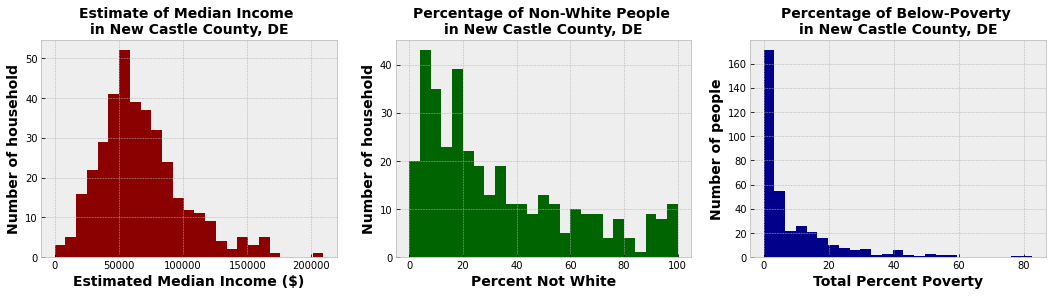

In [28]:
# Figure
fig_nc_demo, ax=plt.subplots(nrows=1, ncols=3, figsize=[18, 6])
plot1 = ax[0]
plot2 = ax[1]
plot3 = ax[2]

nc_demo.hist('mincome', ax=plot1, bins=25, color="darkred")
label_plot(plot1, "Estimate of Median Income \nin New Castle County, DE", "Estimated Median Income ($)", "Number of household", axis_size=14, title_size=14)

nc_demo.hist('per_nonwhite', ax=plot2, bins=25, color="darkgreen")
label_plot(plot2, "Percentage of Non-White People \nin New Castle County, DE", "Percent Not White", "Number of household", axis_size=14, title_size=14)

nc_demo.hist('per_below_povlev', ax=plot3, bins=25, color="darkblue")
label_plot(plot3, "Percentage of Below-Poverty \nin New Castle County, DE", "Total Percent Poverty", "Number of people", axis_size=14, title_size=14)

fig_nc_demo.subplots_adjust(wspace=.2, hspace=.5)
fig_nc_demo.show()

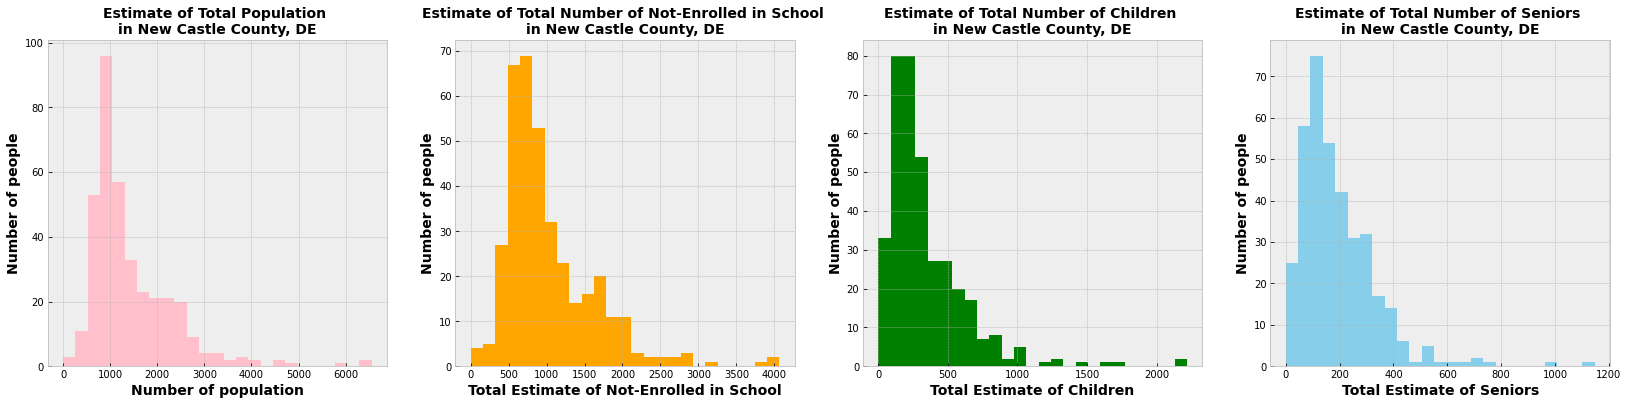

In [29]:
# Figure
fig_nc_demo, ax=plt.subplots(nrows=1, ncols=4, figsize=[28, 6])
plot1 = ax[0]
plot2 = ax[1]
plot3 = ax[2]
plot4 = ax[3]

nc_demo.hist('population', ax=plot1, bins=25, color="pink")
label_plot(plot1, "Estimate of Total Population \nin New Castle County, DE", "Number of population", "Number of people", axis_size=14, title_size=14)

nc_demo.hist('no_school', ax=plot2, bins=25, color="orange")
label_plot(plot2, "Estimate of Total Number of Not-Enrolled in School \nin New Castle County, DE", "Total Estimate of Not-Enrolled in School", "Number of people", axis_size=14, title_size=14)

nc_demo.hist("under18", ax=plot3, bins=25, color="green")
label_plot(plot3, "Estimate of Total Number of Children \nin New Castle County, DE", "Total Estimate of Children", "Number of people", axis_size=14, title_size=14)

nc_demo.hist('over65', ax=plot4, bins=25, color="skyblue")
label_plot(plot4, "Estimate of Total Number of Seniors \nin New Castle County, DE", "Total Estimate of Seniors", "Number of people", axis_size=14, title_size=14)

fig_nc_demo.subplots_adjust(wspace=.2, hspace=.5)
fig_nc_demo.show()


**Fig 3 Socioeconomic demographic (SED) status** Subtitle is the socioeconomic demographic status in New Castle County. The data is estimated from 2014 to 2018 and the data source is from the U.S. Census Bureau. In this figure, the mean of the median household income is $6,7356, the mean of the percentage of not white people is 33.7%, and the rate of the total percentage of poverty is 9.2%.   

# Geocoding: Raster data to Census block group shapefile, Shapefile to SES data


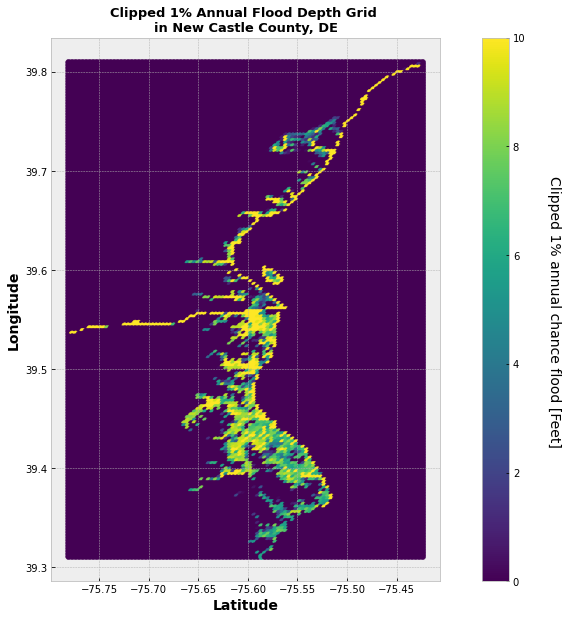

In [70]:
# Raster data preprocessing 
df_dgrid_3c = pd.DataFrame(columns=["lat", "lon", "dep"])
#dep_grid_3c = arr3C_Cst_Dpth01pct
df_dgrid_3c["lat"] = lat_grid_3c.flatten()
df_dgrid_3c["lon"] = lon_grid_3c.flatten()
df_dgrid_3c["dep"] = dep_grid_3c.flatten().astype(float)
def make_point(x):
  return Point(x["lon"], x["lat"])
  make_point(df_dgrid.iloc[0])
df_dgrid_3c["geometry"] = df_dgrid_3c.apply(make_point, axis=1)
df_dgrid = df_dgrid_3c
df_dgrid

df_dgrid_3c = gp.GeoDataFrame(df_dgrid_3c)
df_dgrid = gp.GeoDataFrame(df_dgrid)

#Figure
fig_df_dgrid, ax = plt.subplots()
df_dgrid.plot("dep", ax=ax, legend=True)
label_plot(ax, "Clipped 1% Annual Flood Depth Grid \nin New Castle County, DE", "Latitude", "Longitude", axis_size=14, title_size=13)
fig_df_dgrid.text(0.85, 0.5, "Clipped 1% annual chance flood [Feet]", va="center", ha="center", rotation=-90, fontsize=14)

fig_df_dgrid.savefig("/content/drive/My Drive/flooding/figure/sppa667")

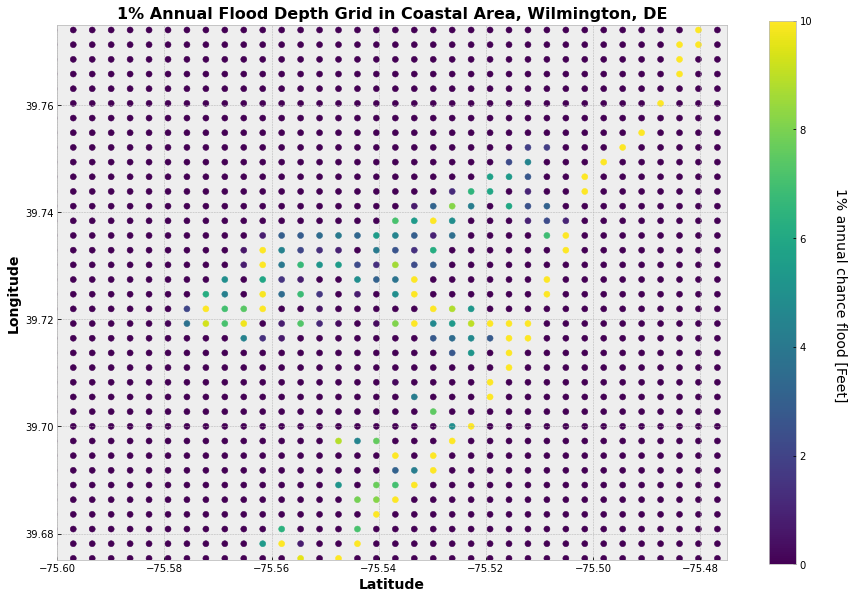

In [72]:
# Wilmington figure
df_dgrid_copy = df_dgrid.copy()

fig_df_dgrid_wm, ax = plt.subplots()
df_dgrid_copy.plot("dep", ax=ax, legend=True)
ax.set_xlim(-75.6, -75.475)
ax.set_ylim(39.675, 39.775)
label_plot(ax, "1% Annual Flood Depth Grid in Coastal Area, Wilmington, DE", "Latitude", "Longitude", axis_size=14, title_size=16)
fig_df_dgrid_wm.text(0.85, 0.5, "1% annual chance flood [Feet]", va="center", ha="center", rotation=-90, fontsize=14)
fig_df_dgrid_wm.savefig("/content/drive/My Drive/flooding/figure/sppa667")

**Fig 4. Flood Depth Grid with Latitude and Longitude** Subtitle is the 1% Annual Flood Depth Grid in Coastal Area, Wilmington, Delaware (Unit:Feet). The data is based on the 2014 raster data from the FEMA. The figure above shows the 1% annual flood depth grid clipped from 0 to 1. The figure shows that the local area surrounded by the Delaware River has the flood risk. 


In [32]:
df_dgrid_3c.columns

Index(['lat', 'lon', 'dep', 'geometry'], dtype='object')

## Geospatial join raster data to census  shapefile

In [33]:
# Perform a spatial join between the Raster data and Census block shape file
df_dgrid_3c_decblkg_2016 = gp.sjoin(df_dgrid_3c, decblkg_2016)
df_dgrid_decblkg_2016 = df_dgrid_3c_decblkg_2016

df_dgrid_3c_decblkg_2016["dep_cl"] = df_dgrid_3c_decblkg_2016["dep"].clip(0, 1e6)
df_dgrid_g = df_dgrid_3c_decblkg_2016.groupby("GEOID").mean().reset_index() # ---get the average number of depth
df_dgrid_sub = df_dgrid_3c_decblkg_2016[["GEOID", "lat", "lon", "dep", "dep_cl"]]
df_dgrid_sub.columns

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  


Index(['GEOID', 'lat', 'lon', 'dep', 'dep_cl'], dtype='object')

In [34]:
# Merge 
decblkg_2016_df_dgrid_sub = decblkg_2016.merge(df_dgrid_sub, on="GEOID")
decblkg_2016_df_dgrid_sub
decblkg_2016_df_dgrid_sub_cols = decblkg_2016_df_dgrid_sub[["GEOID", "lat", "lon", "dep", "dep_cl", "geometry", "AWATER", "ALAND"]]

## Set distance to the water

In [35]:
data16 = decblkg_2016_df_dgrid_sub_cols
# Calculate the fraction of the water area (to add new feature)
data16["water_frac"] = data16.AWATER / (data16.ALAND + data16.AWATER) 
data16.describe()

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,lat,lon,dep,dep_cl,AWATER,ALAND,water_frac
count,13840.000000,13840.000000,13840.000000,13840.000000,1.384000e+04,1.384000e+04,13840.000000
mean,39.558899,-75.632666,0.731351,0.731351,2.514741e+07,2.378278e+07,0.162478
std,0.151157,0.084464,2.339364,2.339364,8.040556e+07,3.322450e+07,0.316580
min,39.310938,-75.780931,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,39.419852,-75.703124,0.000000,0.000000,0.000000e+00,2.039224e+06,0.000000
50%,39.561646,-75.635927,0.000000,0.000000,1.890080e+05,1.210273e+07,0.024321
75%,39.694536,-75.568730,0.000000,0.000000,4.708183e+06,3.065568e+07,0.109787
max,39.809615,-75.423726,10.000000,10.000000,4.959192e+08,1.703789e+08,1.000000


In [36]:
# Calculate the water area (to add new feature)
threshold = 0.05
data16["has_water"] = data16.water_frac > threshold
# Subset the land area over 0 (to exclude the water basin area in maps)
(data16.ALAND > 0).sum() # Not entirely water
data16 = data16[data16.ALAND >0]
data16

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,GEOID,lat,lon,dep,dep_cl,geometry,AWATER,ALAND,water_frac,has_water
0,100030147052,39.664396,-75.720807,0.0,0.0,"POLYGON ((-75.73365 39.65395, -75.73347 39.653...",0,2747580,0.000000,False
1,100030147052,39.661656,-75.724344,0.0,0.0,"POLYGON ((-75.73365 39.65395, -75.73347 39.653...",0,2747580,0.000000,False
2,100030147052,39.661656,-75.720807,0.0,0.0,"POLYGON ((-75.73365 39.65395, -75.73347 39.653...",0,2747580,0.000000,False
3,100030147052,39.661656,-75.717271,0.0,0.0,"POLYGON ((-75.73365 39.65395, -75.73347 39.653...",0,2747580,0.000000,False
4,100030147052,39.661656,-75.713734,0.0,0.0,"POLYGON ((-75.73365 39.65395, -75.73347 39.653...",0,2747580,0.000000,False
...,...,...,...,...,...,...,...,...,...,...
13835,100030169042,39.310938,-75.586413,5.8,5.8,"POLYGON ((-75.66163 39.37267, -75.66151 39.372...",7441873,93018625,0.074078,True
13836,100030169042,39.310938,-75.582877,0.0,0.0,"POLYGON ((-75.66163 39.37267, -75.66151 39.372...",7441873,93018625,0.074078,True
13837,100030015001,39.752075,-75.561656,0.0,0.0,"POLYGON ((-75.56277 39.75075, -75.56241 39.751...",23880,198949,0.107167,True
13838,100030015001,39.752075,-75.558120,0.0,0.0,"POLYGON ((-75.56277 39.75075, -75.56241 39.751...",23880,198949,0.107167,True


## Merge geodata to SED factors data 

In [37]:
# New Castle
data16_nc_demo = data16.merge(nc_demo, left_on="GEOID", right_on="cblockgid",how="left")
nc_data = data16_nc_demo
nc_data["no_school_frac"] = nc_data.no_school / nc_data.population
cols = ["cblockgid", "geometry", "lat", "lon",
        "dep", "dep_cl", 
        "mincome", "per_nonwhite", "per_below_povlev", "population", "no_school","no_school_frac", "under18", "over65", "has_water"]
nc_data_sub = nc_data[cols]
nc_data_sub.columns = ["cblockgid", "geometry", "lat", "lon", "dep", "dep_cl",  
                       "mincome", "per_nonwhite", "per_below_povlev", "population", "no_school", "no_school_frac", "under18", "over65", "has_water"]
nc_data_sub = nc_data_sub.dropna()
nc_data_sub

,cblockgid,geometry,lat,lon,dep,dep_cl,mincome,per_nonwhite,per_below_povlev,population,no_school,no_school_frac,under18,over65,has_water
0,100030147052,"POLYGON ((-75.73365 39.65395, -75.73347 39.653...",39.664396,-75.720807,0.0,0.0,76142.0,20.987654,2.682927,1458.0,1056.0,0.724280,310.0,214.0,False
1,100030147052,"POLYGON ((-75.73365 39.65395, -75.73347 39.653...",39.661656,-75.724344,0.0,0.0,76142.0,20.987654,2.682927,1458.0,1056.0,0.724280,310.0,214.0,False
2,100030147052,"POLYGON ((-75.73365 39.65395, -75.73347 39.653...",39.661656,-75.720807,0.0,0.0,76142.0,20.987654,2.682927,1458.0,1056.0,0.724280,310.0,214.0,False
3,100030147052,"POLYGON ((-75.73365 39.65395, -75.73347 39.653...",39.661656,-75.717271,0.0,0.0,76142.0,20.987654,2.682927,1458.0,1056.0,0.724280,310.0,214.0,False
4,100030147052,"POLYGON ((-75.73365 39.65395, -75.73347 39.653...",39.661656,-75.713734,0.0,0.0,76142.0,20.987654,2.682927,1458.0,1056.0,0.724280,310.0,214.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12200,100030169042,"POLYGON ((-75.66163 39.37267, -75.66151 39.372...",39.310938,-75.586413,5.8,5.8,51701.0,1.851852,3.333333,1233.0,963.0,0.781022,217.0,226.0,True
12201,100030169042,"POLYGON ((-75.66163 39.37267, -75.66151 39.372...",39.310938,-75.582877,0.0,0.0,51701.0,1.851852,3.333333,1233.0,963.0,0.781022,217.0,226.0,True
12202,100030015001,"POLYGON ((-75.56277 39.75075, -75.56241 39.751...",39.752075,-75.561656,0.0,0.0,18634.0,18.888889,0.000000,810.0,679.0,0.838272,99.0,337.0,True
12203,100030015001,"POLYGON ((-75.56277 39.75075, -75.56241 39.751...",39.752075,-75.558120,0.0,0.0,18634.0,18.888889,0.000000,810.0,679.0,0.838272,99.0,337.0,True


# Making a single plot 


In [38]:
import matplotlib.pyplot as plt

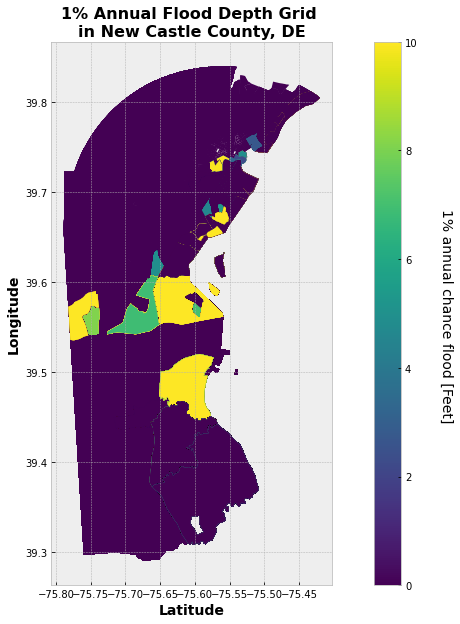

In [73]:
fig_fld, ax = plt.subplots()
nc_data_sub.plot("dep", ax=ax, legend=True)
label_plot(ax, "1% Annual Flood Depth Grid \nin New Castle County, DE", "Latitude", "Longitude", axis_size=14, title_size=16)
fig_fld.text(0.85, 0.5, "1% annual chance flood [Feet]", va="center", ha="center", rotation=-90, fontsize=14)
fig_fld.savefig("/content/drive/My Drive/flooding/figure/sppa667")

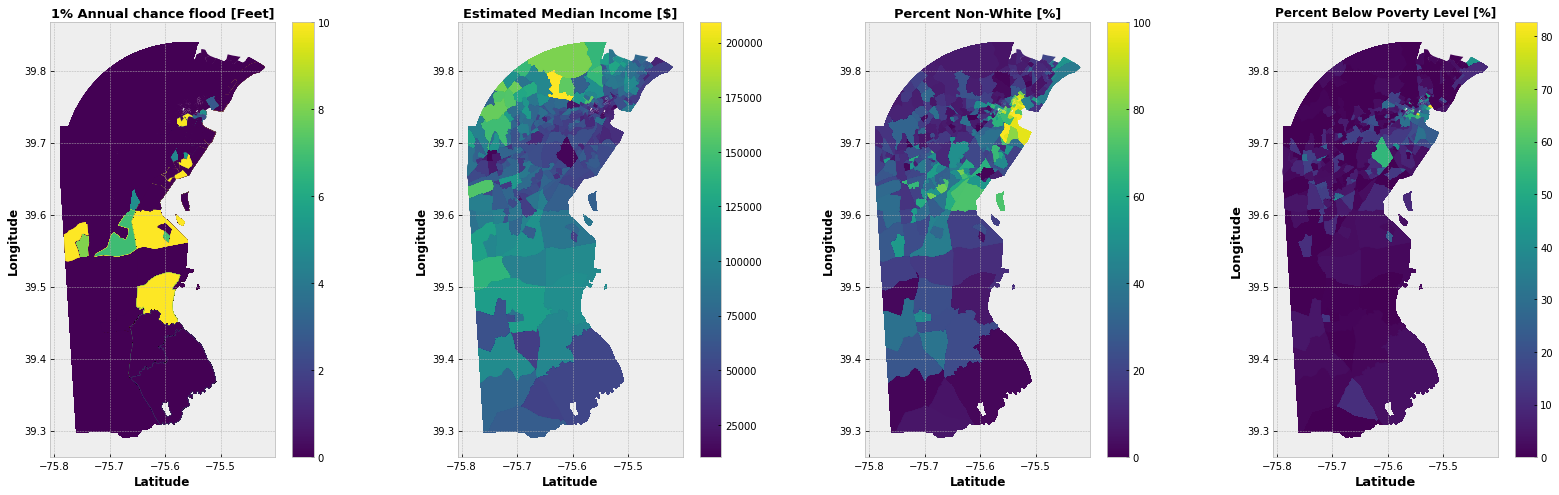

In [54]:
# Plot
fig_nc_data_sub, ax=plt.subplots(nrows=1, ncols=4, figsize=[28, 8])
plot1 = ax[0]
plot2 = ax[1]
plot3 = ax[2]
plot4 = ax[3]

nc_data_sub.plot("dep", ax=plot1, legend=True)
label_plot(plot1, "1% Annual chance flood [Feet]", "Latitude", "Longitude", axis_size=12, title_size=13)

nc_data_sub.plot("mincome", ax=plot2, legend=True)
label_plot(plot2, "Estimated Median Income [$]", "Latitude", "Longitude", axis_size=12, title_size=13)

nc_data_sub.plot("per_nonwhite", ax=plot3, legend=True)
label_plot(plot3, "Percent Non-White [%]", "Latitude", "Longitude", axis_size=12, title_size=13)

nc_data_sub.plot("per_below_povlev", ax=plot4, legend=True)
label_plot(plot4,  "Percent Below Poverty Level [%]", "Latitude", "Longitude", title_size=12, axis_size=13)

fig_nc_data_sub.show()
#fig_nc_data_sub.savefig("/content/drive/My Drive/flooding/figure/sppa667")

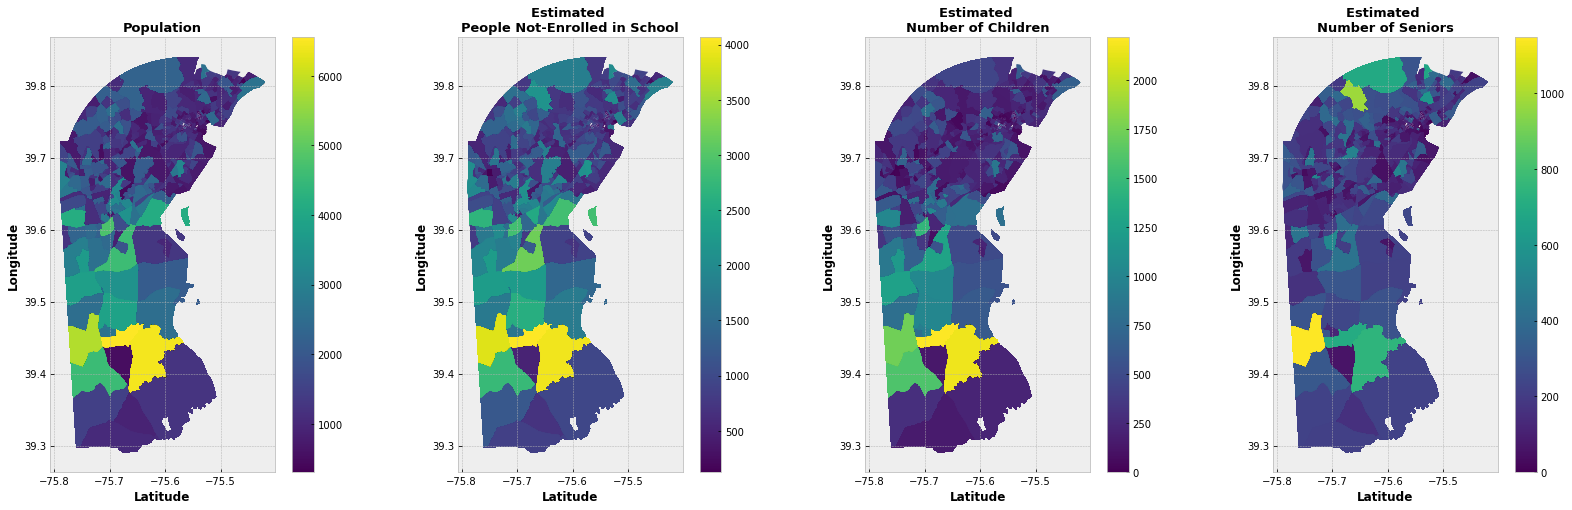

In [53]:
# Plot
fig_nc_data_sub, ax=plt.subplots(nrows=1, ncols=4, figsize=[28, 8])
plot1 = ax[0]
plot2 = ax[1]
plot3 = ax[2]
plot4 = ax[3]

nc_data_sub.plot("population", ax=plot1, legend=True)
label_plot(plot1, "Population", "Latitude", "Longitude", axis_size=12, title_size=13)

nc_data_sub.plot("no_school", ax=plot2, legend=True)
label_plot(plot2, "Estimated \nPeople Not-Enrolled in School", "Latitude", "Longitude", axis_size=12, title_size=13)

nc_data_sub.plot("under18", ax=plot3, legend=True)
label_plot(plot3, "Estimated \nNumber of Children", "Latitude", "Longitude", axis_size=12, title_size=13)

nc_data_sub.plot("over65", ax=plot4, legend=True)
label_plot(plot4, "Estimated \nNumber of Seniors", "Latitude", "Longitude", axis_size=12, title_size=13)

fig_nc_data_sub.show()
#fig_nc_data_sub.savefig("/content/drive/My Drive/flooding/figure/sppa667")

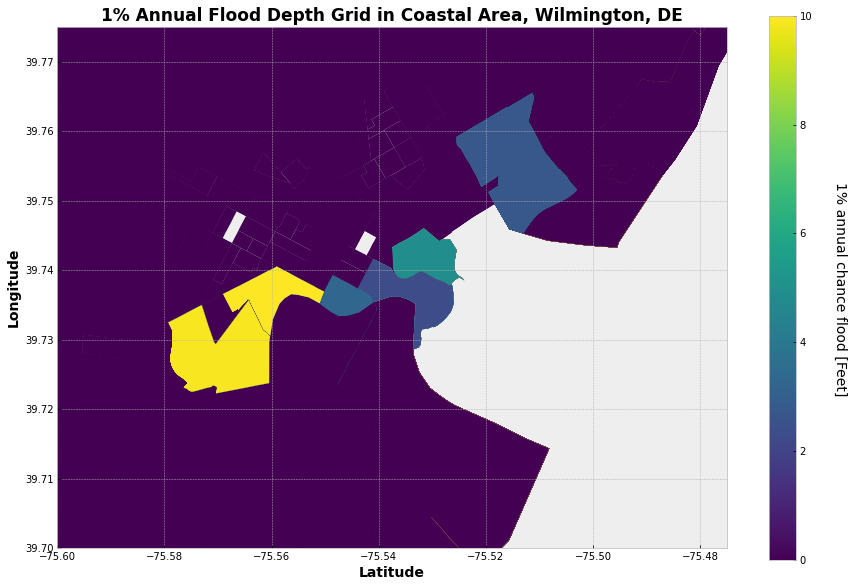

In [74]:
fig, ax = plt.subplots()
nc_data_sub.plot("dep", legend=True, ax=ax)
ax.set_xlim(-75.6, -75.475)
ax.set_ylim(39.7, 39.775)
fig.text(0.85, 0.5, "1% annual chance flood [Feet]", va="center", ha="center", rotation=-90, fontsize=14)
label_plot(ax, "1% Annual Flood Depth Grid in Coastal Area, Wilmington, DE", "Latitude", "Longitude", axis_size=14, title_size=17)

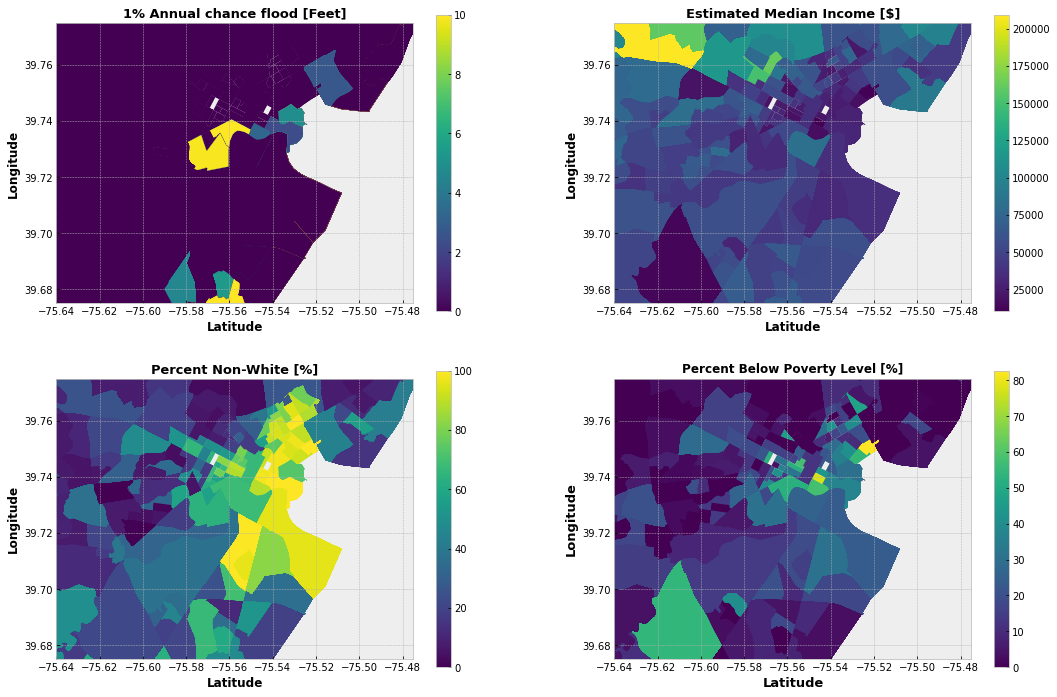

In [64]:
# Plot
fig_nc_data_sub_wm, ax=plt.subplots(nrows=2, ncols=2, figsize=[18, 12])
plot1 = ax[0,0]
plot2 = ax[0,1]
plot3 = ax[1,0]
plot4 = ax[1,1]

nc_data_sub.plot("dep", ax=plot1, legend=True)
plot1.set_xlim(-75.64, -75.475)
plot1.set_ylim(39.675, 39.775)
label_plot(plot1, "1% Annual chance flood [Feet]", "Latitude", "Longitude", axis_size=12, title_size=13)

nc_data_sub.plot("mincome", ax=plot2, legend=True)
plot2.set_xlim(-75.64, -75.475)
plot2.set_ylim(39.675, 39.775)
label_plot(plot2, "Estimated Median Income [$]", "Latitude", "Longitude", axis_size=12, title_size=13)

nc_data_sub.plot("per_nonwhite", ax=plot3, legend=True)
plot3.set_xlim(-75.64, -75.475)
plot3.set_ylim(39.675, 39.775)
label_plot(plot3, "Percent Non-White [%]", "Latitude", "Longitude", axis_size=12, title_size=13)

nc_data_sub.plot("per_below_povlev", ax=plot4, legend=True)
plot4.set_xlim(-75.64, -75.475)
plot4.set_ylim(39.675, 39.775)
label_plot(plot4, "Percent Below Poverty Level [%]", "Latitude", "Longitude", title_size=12, axis_size=13)

fig_nc_data_sub_wm.subplots_adjust(wspace=.25)
fig_nc_data_sub_wm.show()


**Fig 5. Flood depth and SED results** Subtitle is the 1% Annual Flood Depth Grid and Socioeconomic Demographic Status in Coastal Area, Wilmington, Delaware. The figure above shows the urban area around the Delaware River in the city is exposed to the 1% annual flood risk. This area is surrounded by the minority who are under average medeian household income, not white, and below povert line. 

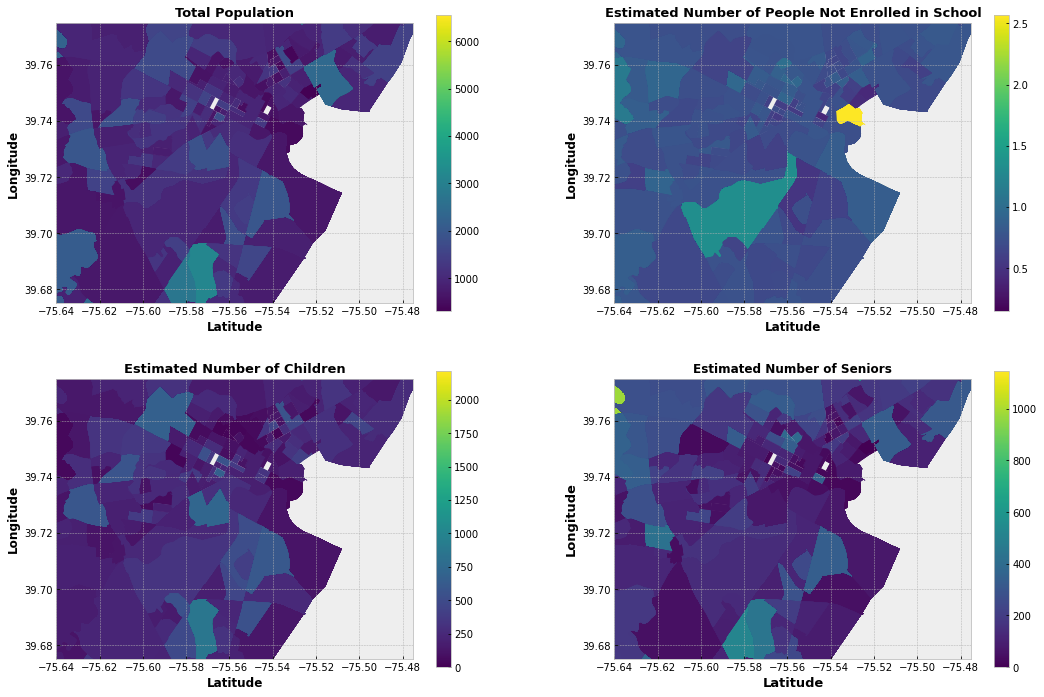

In [69]:
# Plot
fig_nc_data_sub_wm, ax=plt.subplots(nrows=2, ncols=2, figsize=[18, 12])
plot1 = ax[0,0]
plot2 = ax[0,1]
plot3 = ax[1,0]
plot4 = ax[1,1]

nc_data_sub.plot("population", ax=plot1, legend=True)
plot1.set_xlim(-75.64, -75.475)
plot1.set_ylim(39.675, 39.775)
label_plot(plot1, "Total Population", "Latitude", "Longitude", axis_size=12, title_size=13)

nc_data_sub.plot("no_school_frac", ax=plot2, legend=True)
plot2.set_xlim(-75.64, -75.475)
plot2.set_ylim(39.675, 39.775)
label_plot(plot2, "Estimated Number of People Not Enrolled in School", "Latitude", "Longitude", axis_size=12, title_size=13)

nc_data_sub.plot("under18", ax=plot3, legend=True)
plot3.set_xlim(-75.64, -75.475)
plot3.set_ylim(39.675, 39.775)
label_plot(plot3, "Estimated Number of Children", "Latitude", "Longitude", axis_size=12, title_size=13)

nc_data_sub.plot("over65", ax=plot4, legend=True)
plot4.set_xlim(-75.64, -75.475)
plot4.set_ylim(39.675, 39.775)
label_plot(plot4, "Estimated Number of Seniors", "Latitude", "Longitude", title_size=12, axis_size=13)

fig_nc_data_sub_wm.subplots_adjust(wspace=.25)
fig_nc_data_sub_wm.show()

#fig_nc_data_sub_wm.savefig("/content/drive/My Drive/flooding/figure/sppa667")

**Discussion and Conclusion** Through this project (homework 9), I found the area where the minority relatively lives more than the other area has more possibilities to expose to the flood risk. This issue can be related to the environmental justice, and therefore I look forward to make policy implications based on the data in terms of the data science and urban policy integration. However, this research still has the limitation in that the most recent data of the flood depth is based on 2014 and county level.


## Subset Census Block Groups of the Wilmington City

http://www.usa.com/wilmington-de.htm

In [44]:
nc_data_sub_copy = nc_data_sub.copy()
len(nc_data_sub_copy)

11652

In [45]:
cblockgid_wil = nc_data_sub_copy["cblockgid"].str.contains('100030002001|100030002002|100030002003|100030002004|100030002005|100030002006|100030003001|100030003002|100030003003|100030003004|100030004001|100030004002|100030004003|100030005001|100030005002|100030005003|100030005004|100030006011|100030006012|100030006013|100030006011|100030006021|100030006022|100030006023|1000300030021|1000300030022|1000300030023|100039801001|100030013001|100030013002|100030013003|100030013004|100030012001|100030012002|100030011001|100030011001|100030011002|100030011003|100030014001|100030014002|100030016001|100030016002|100030016003|100030024001|100030024002|100030024003|100030024004|100030025001|100030025002|100030025003|100030023001|100030023002|100030023003|100030022001|100030022002|100030022003|100030026001|100030026002|100030026003|100030026004|100030026001|100030027001|100030027002|100030026001|100030021001|100030021002|100030027001|100030028001|100030028002|100030029001|100030029002|100030029003|100030029004|100039801001|100030019022|100030009001|100030009002|100030009003|100030009004|100030015001|100030015002|100030023001')
nc_data_sub_wil = nc_data_sub_copy[cblockgid_wil]
nc_data_sub_wil 
len(nc_data_sub_wil)

203

In [108]:
nc_data_sub_wil["no_school_frac"] = nc_data_sub_wil.no_school / nc_data_sub_wil.population
nc_data_sub_wil["has_water_int"] = nc_data_sub_wil.has_water * 1

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


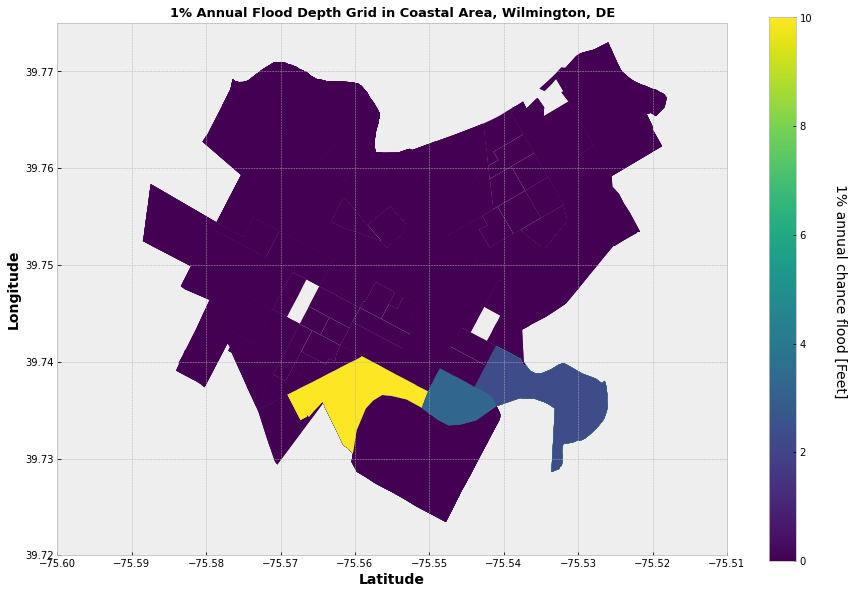

In [109]:
fig, ax = plt.subplots()
nc_data_sub_wil.plot("dep_cl", legend=True, ax=ax)
ax.set_xlim(-75.60, -75.51)
ax.set_ylim(39.72, 39.775)
fig.text(0.85, 0.5, "1% annual chance flood [Feet]", va="center", ha="center", rotation=-90, fontsize=14)
label_plot(ax, "1% Annual Flood Depth Grid in Coastal Area, Wilmington, DE", "Latitude", "Longitude", axis_size=14, title_size=13)

In [110]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

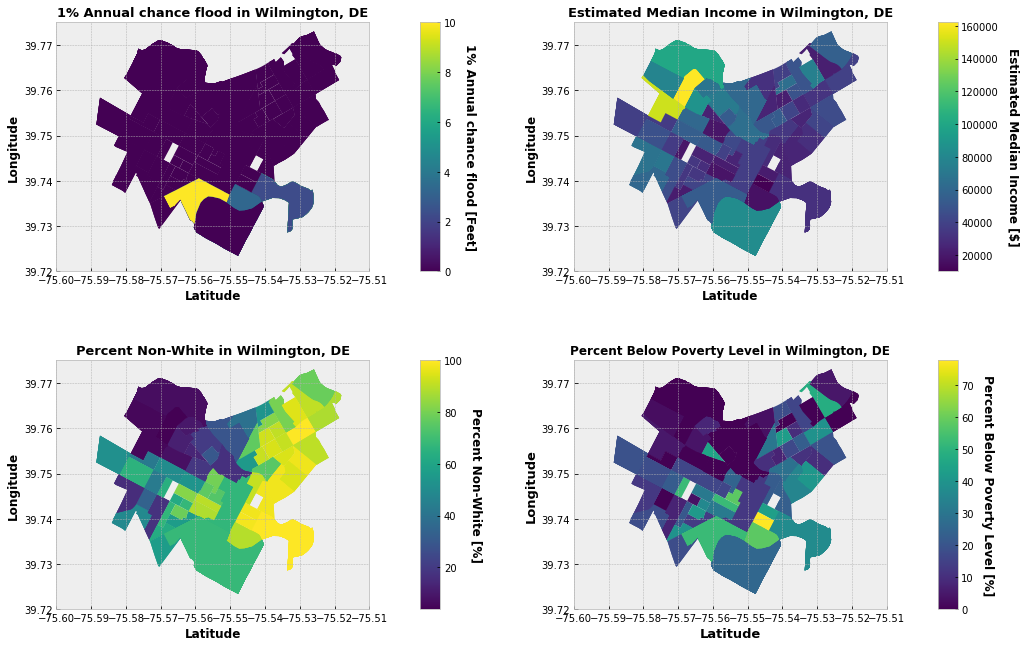

In [111]:
# Plot
fig_nc_data_sub_wm, ax=plt.subplots(nrows=2, ncols=2, figsize=[17, 11])
plot1 = ax[0,0]
plot2 = ax[0,1]
plot3 = ax[1,0]
plot4 = ax[1,1]

#plot1
divider1 = make_axes_locatable(plot1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05) 
nc_data_sub_wil.plot("dep", ax=plot1, legend=True, cax=cax1)
plot1.set_xlim(-75.60, -75.51)
plot1.set_ylim(39.72, 39.775)
cax1.set_ylabel("1% Annual chance flood [Feet]", rotation=270, weight="bold", size=12, labelpad=20)
label_plot(plot1, "1% Annual chance flood in Wilmington, DE", "Latitude", "Longitude", axis_size=12, title_size=13)

#plot2
divider2 = make_axes_locatable(plot2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05) 
nc_data_sub_wil.plot("mincome", ax=plot2, legend=True, cax=cax2)
plot2.set_xlim(-75.60, -75.51)
plot2.set_ylim(39.72, 39.775)
cax2.set_ylabel("Estimated Median Income [$]", rotation=270, weight="bold", size=12, labelpad=20)
label_plot(plot2, "Estimated Median Income in Wilmington, DE", "Latitude", "Longitude", axis_size=12, title_size=13)

#plot3
divider3 = make_axes_locatable(plot3)
cax3 = divider3.append_axes("right", size="5%", pad=0.05) 
nc_data_sub_wil.plot("per_nonwhite", ax=plot3, legend=True, cax=cax3)
plot3.set_xlim(-75.60, -75.51)
plot3.set_ylim(39.72, 39.775)
cax3.set_ylabel("Percent Non-White [%]", rotation=270, weight="bold", size=12, labelpad=20)
label_plot(plot3, "Percent Non-White in Wilmington, DE", "Latitude", "Longitude", axis_size=12, title_size=13)

#plot4
divider4 = make_axes_locatable(plot4)
cax4 = divider4.append_axes("right", size="5%", pad=0.05) 
nc_data_sub_wil.plot("per_below_povlev", ax=plot4, legend=True, cax=cax4)
plot4.set_xlim(-75.60, -75.51)
plot4.set_ylim(39.72, 39.775)
cax4.set_ylabel("Percent Below Poverty Level [%]", rotation=270, weight="bold", size=12, labelpad=20)
label_plot(plot4, "Percent Below Poverty Level in Wilmington, DE", "Latitude", "Longitude", title_size=12, axis_size=13)

fig_nc_data_sub_wm.subplots_adjust(wspace=.2, hspace=.3)
fig_nc_data_sub_wm.show()

fig_nc_data_sub_wm.savefig("/content/drive/My Drive/flooding/figure/sppa667")

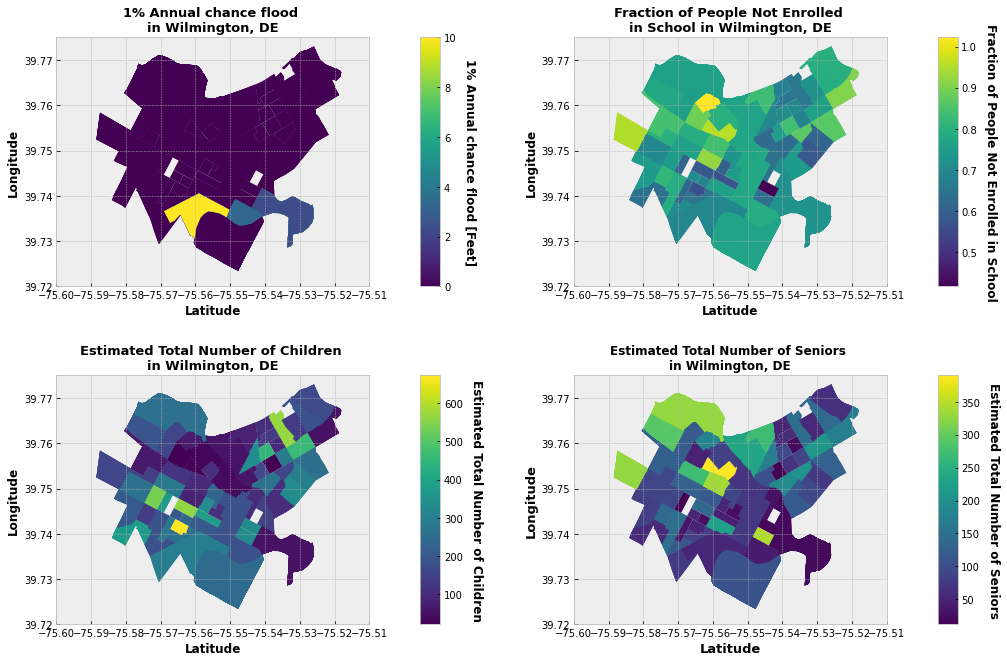

In [112]:
# Plot
fig_nc_data_sub_wm2, ax=plt.subplots(nrows=2, ncols=2, figsize=[17, 11])
plot1 = ax[0,0]
plot2 = ax[0,1]
plot3 = ax[1,0]
plot4 = ax[1,1]

#plot1
divider1 = make_axes_locatable(plot1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05) 
nc_data_sub_wil.plot("dep", ax=plot1, legend=True, cax=cax1)
plot1.set_xlim(-75.60, -75.51)
plot1.set_ylim(39.72, 39.775)
cax1.set_ylabel("1% Annual chance flood [Feet]", rotation=270, weight="bold", size=12, labelpad=20)
label_plot(plot1, "1% Annual chance flood \nin Wilmington, DE", "Latitude", "Longitude", axis_size=12, title_size=13)

#plot2
divider2 = make_axes_locatable(plot2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05) 
nc_data_sub_wil.plot("no_school_frac", ax=plot2, legend=True, cax=cax2)
plot2.set_xlim(-75.60, -75.51)
plot2.set_ylim(39.72, 39.775)
cax2.set_ylabel("Fraction of People Not Enrolled in School", rotation=270, weight="bold", size=12, labelpad=20)
label_plot(plot2, "Fraction of People Not Enrolled \nin School in Wilmington, DE", "Latitude", "Longitude", axis_size=12, title_size=13)

#plot3
divider3 = make_axes_locatable(plot3)
cax3 = divider3.append_axes("right", size="5%", pad=0.05) 
nc_data_sub_wil.plot("under18", ax=plot3, legend=True, cax=cax3)
plot3.set_xlim(-75.60, -75.51)
plot3.set_ylim(39.72, 39.775)
cax3.set_ylabel("Estimated Total Number of Children", rotation=270, weight="bold", size=12, labelpad=20)
label_plot(plot3, "Estimated Total Number of Children \nin Wilmington, DE", "Latitude", "Longitude", axis_size=12, title_size=13)

#plot4
divider4 = make_axes_locatable(plot4)
cax4 = divider4.append_axes("right", size="5%", pad=0.05) 
nc_data_sub_wil.plot("over65", ax=plot4, legend=True, cax=cax4)
plot4.set_xlim(-75.60, -75.51)
plot4.set_ylim(39.72, 39.775)
cax4.set_ylabel("Estimated Total Number of Seniors", rotation=270, weight="bold", size=12, labelpad=20)
label_plot(plot4, "Estimated Total Number of Seniors \nin Wilmington, DE", "Latitude", "Longitude", title_size=12, axis_size=13)

fig_nc_data_sub_wm2.subplots_adjust(wspace=.2, hspace=.3)
fig_nc_data_sub_wm2.show()

fig_nc_data_sub_wm2.savefig("/content/drive/My Drive/flooding/figure/sppa667")

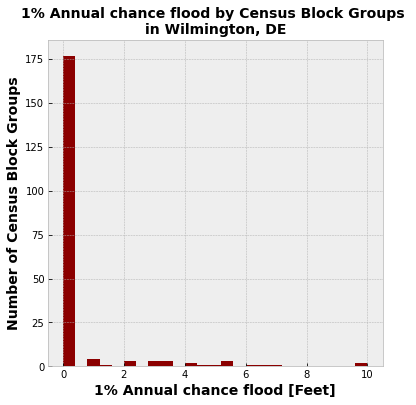

In [113]:
fig_nc_data_sub_wil, ax=plt.subplots(nrows=1, ncols=1, figsize=[6, 6])
plot1 = ax
nc_data_sub_wil.hist('dep_cl', ax=plot1, bins=25, color="darkred")
label_plot(plot1, "1% Annual chance flood by Census Block Groups \nin Wilmington, DE", "1% Annual chance flood [Feet]", "Number of Census Block Groups", axis_size=14, title_size=14)

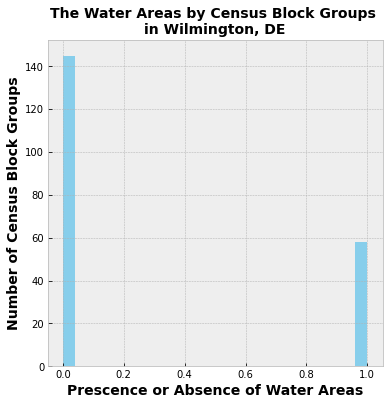

In [114]:
fig_nc_data_sub_wil, ax=plt.subplots(nrows=1, ncols=1, figsize=[6, 6])
plot1 = ax
nc_data_sub_wil.hist('has_water_int', ax=plot1, bins=25, color="skyblue")
label_plot(plot1, "The Water Areas by Census Block Groups \nin Wilmington, DE", "Prescence or Absence of Water Areas", "Number of Census Block Groups", axis_size=14, title_size=14)

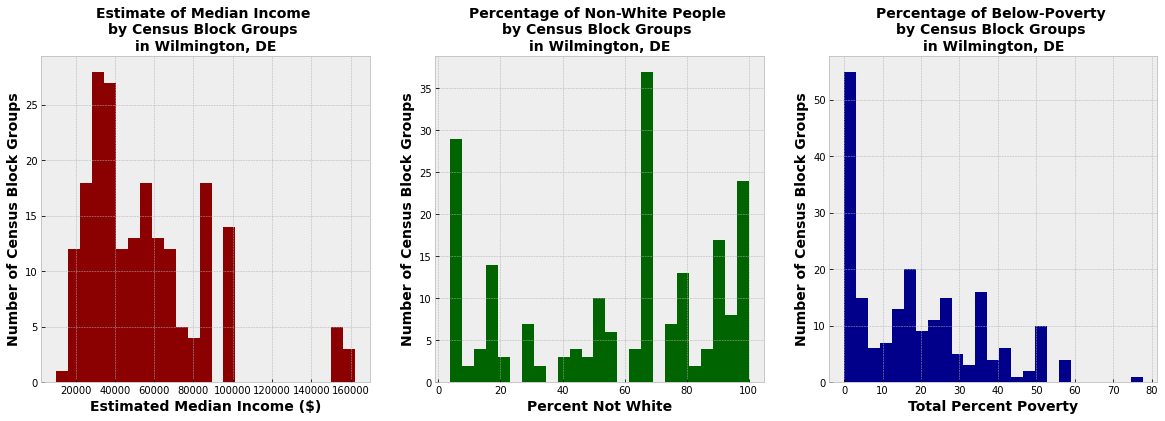

In [115]:
# Figure
fig_nc_data_sub_wil, ax=plt.subplots(nrows=1, ncols=3, figsize=[20, 6])
plot1 = ax[0]
plot2 = ax[1]
plot3 = ax[2]

nc_data_sub_wil.hist('mincome', ax=plot1, bins=25, color="darkred")
label_plot(plot1, "Estimate of Median Income \nby Census Block Groups \nin Wilmington, DE", "Estimated Median Income ($)", "Number of Census Block Groups", axis_size=14, title_size=14)

nc_data_sub_wil.hist('per_nonwhite', ax=plot2, bins=25, color="darkgreen")
label_plot(plot2, "Percentage of Non-White People \nby Census Block Groups \nin Wilmington, DE", "Percent Not White", "Number of Census Block Groups", axis_size=14, title_size=14)

nc_data_sub_wil.hist('per_below_povlev', ax=plot3, bins=25, color="darkblue")
label_plot(plot3, "Percentage of Below-Poverty \nby Census Block Groups \nin Wilmington, DE", "Total Percent Poverty", "Number of Census Block Groups", axis_size=14, title_size=14)

fig_nc_data_sub_wil.subplots_adjust(wspace=.2, hspace=.5)
fig_nc_data_sub_wil.show()

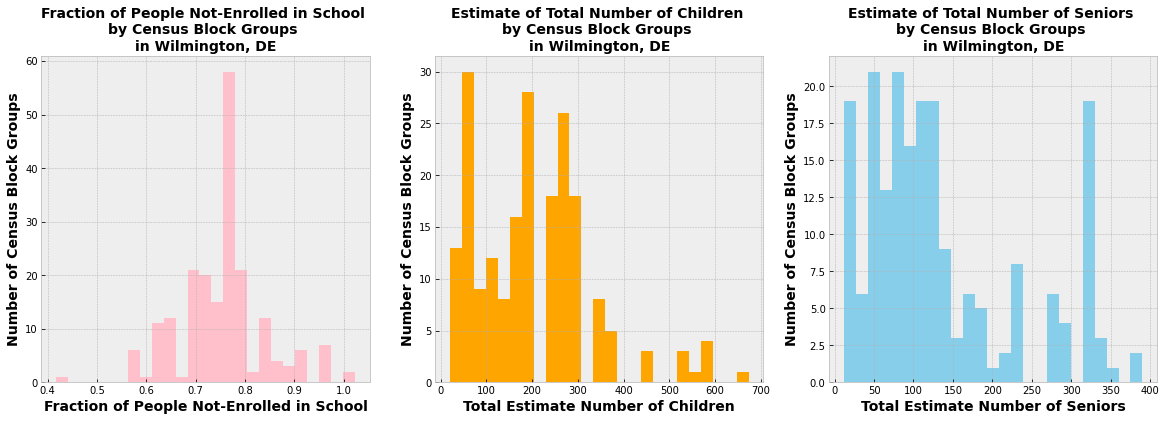

In [116]:
# Figure
fig_nc_data_sub_wil, ax=plt.subplots(nrows=1, ncols=3, figsize=[20, 6])
plot1 = ax[0]
plot2 = ax[1]
plot3 = ax[2]

nc_data_sub_wil.hist('no_school_frac', ax=plot1, bins=25, color="pink")
label_plot(plot1, "Fraction of People Not-Enrolled in School \nby Census Block Groups \nin Wilmington, DE", "Fraction of People Not-Enrolled in School", "Number of Census Block Groups", axis_size=14, title_size=14)

nc_data_sub_wil.hist('under18', ax=plot2, bins=25, color="orange")
label_plot(plot2, "Estimate of Total Number of Children \nby Census Block Groups \nin Wilmington, DE", "Total Estimate Number of Children", "Number of Census Block Groups", axis_size=14, title_size=14)

nc_data_sub_wil.hist("over65", ax=plot3, bins=25, color="skyblue")
label_plot(plot3, "Estimate of Total Number of Seniors \nby Census Block Groups \nin Wilmington, DE", "Total Estimate Number of Seniors", "Number of Census Block Groups", axis_size=14, title_size=14)

fig_nc_data_sub_wil.subplots_adjust(wspace=.2, hspace=.5)
fig_nc_data_sub_wil.show()

In [117]:
nc_data_sub_wil.describe()

,lat,lon,dep,dep_cl,mincome,per_nonwhite,per_below_povlev,population,no_school,no_school_frac,under18,over65,has_water_int
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000
mean,39.750172,-75.553137,0.516256,0.516256,55261.177340,57.237379,18.446325,967.147783,727.669951,0.756534,200.970443,135.093596,0.285714
std,0.011163,0.016557,1.620714,1.620714,30641.633629,32.408620,17.069917,315.344881,232.317797,0.087995,128.113460,98.604802,0.452871
min,39.724676,-75.586413,0.000000,0.000000,10177.000000,3.810976,0.000000,389.000000,280.000000,0.417404,21.000000,12.000000,0.000000
25%,39.741115,-75.565193,0.000000,0.000000,32206.000000,20.620621,2.692308,719.500000,576.000000,0.701105,99.000000,64.000000,0.000000
50%,39.752075,-75.554583,0.000000,0.000000,47976.000000,66.979362,16.071429,962.000000,745.000000,0.762509,187.000000,108.000000,0.000000
75%,39.760295,-75.540436,0.000000,0.000000,69403.500000,88.115942,28.991597,1141.000000,876.000000,0.793226,261.000000,178.000000,1.000000
max,39.771255,-75.519216,10.000000,10.000000,162143.000000,100.000000,77.600000,1792.000000,1179.000000,1.022071,673.000000,390.000000,1.000000


#Correlation

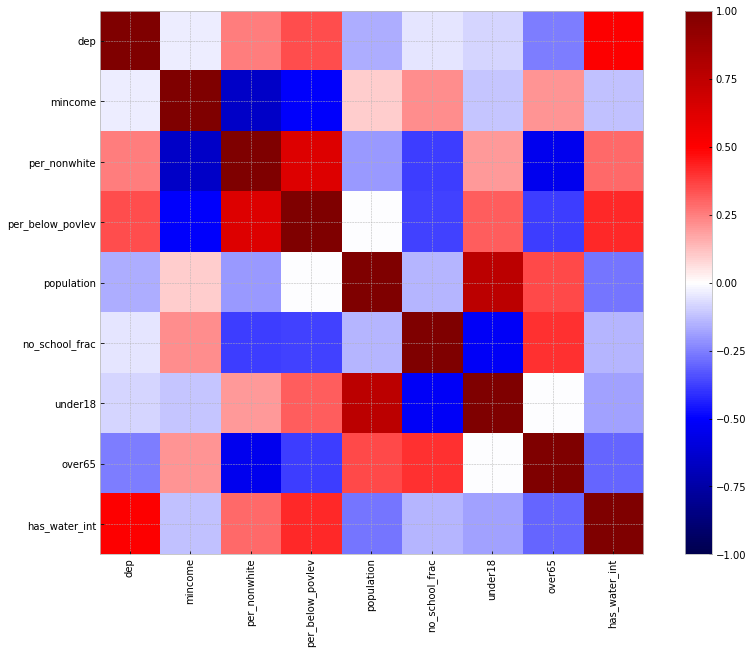

In [118]:
nc_data_wil2 = nc_data_sub_wil[['dep', 'mincome', 'per_nonwhite', 'per_below_povlev', 'population', 'no_school_frac', 'under18', 'over65', "has_water_int"]]
plt.imshow(nc_data_wil2.corr(), clim=(-1,+1), cmap='seismic')
plt.yticks(range(len(nc_data_wil2.corr())), nc_data_wil2.corr().columns)
plt.xticks(range(len(nc_data_wil2.corr())), nc_data_wil2.corr().columns, rotation='vertical')
plt.colorbar()

# Machine Learning


In [120]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

plt.style.use("bmh")

## model preprocessing

In [121]:
data = nc_data_sub_wil
data

,cblockgid,geometry,lat,lon,dep,dep_cl,mincome,per_nonwhite,per_below_povlev,population,no_school,no_school_frac,under18,over65,has_water,has_water_int
1254,100030028001,"POLYGON ((-75.55731 39.73991, -75.55730 39.740...",39.746595,-75.551046,0.0,0.0,37550.0,66.979362,12.582781,962.0,750.0,0.779626,184.0,74.0,False,0
1255,100030028001,"POLYGON ((-75.55731 39.73991, -75.55730 39.740...",39.746595,-75.547510,0.0,0.0,37550.0,66.979362,12.582781,962.0,750.0,0.779626,184.0,74.0,False,0
1256,100030028001,"POLYGON ((-75.55731 39.73991, -75.55730 39.740...",39.746595,-75.543973,0.0,0.0,37550.0,66.979362,12.582781,962.0,750.0,0.779626,184.0,74.0,False,0
1257,100030028001,"POLYGON ((-75.55731 39.73991, -75.55730 39.740...",39.743855,-75.551046,0.0,0.0,37550.0,66.979362,12.582781,962.0,750.0,0.779626,184.0,74.0,False,0
1258,100030028001,"POLYGON ((-75.55731 39.73991, -75.55730 39.740...",39.743855,-75.547510,0.0,0.0,37550.0,66.979362,12.582781,962.0,750.0,0.779626,184.0,74.0,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10941,100030023003,"POLYGON ((-75.57454 39.74702, -75.57423 39.747...",39.749335,-75.568730,0.0,0.0,36477.0,43.610935,22.188450,1573.0,1179.0,0.749523,537.0,89.0,False,0
10942,100030023003,"POLYGON ((-75.57454 39.74702, -75.57423 39.747...",39.746595,-75.572267,0.0,0.0,36477.0,43.610935,22.188450,1573.0,1179.0,0.749523,537.0,89.0,False,0
12202,100030015001,"POLYGON ((-75.56277 39.75075, -75.56241 39.751...",39.752075,-75.561656,0.0,0.0,18634.0,18.888889,0.000000,810.0,679.0,0.838272,99.0,337.0,True,1
12203,100030015001,"POLYGON ((-75.56277 39.75075, -75.56241 39.751...",39.752075,-75.558120,0.0,0.0,18634.0,18.888889,0.000000,810.0,679.0,0.838272,99.0,337.0,True,1


In [122]:
# Set dataframe

fld_unshuffled = data


fld_values = fld_unshuffled['dep_cl'].values 

fld_class_groups = []
for i in fld_values:
  if i == 0:
    fld_class_groups.append(0)
  else:
    fld_class_groups.append(1)

fld_unshuffled['fld_present'] = fld_class_groups

# Set 0 and 1 values 
fld_unshuffled_yes = fld_unshuffled[fld_unshuffled['fld_present']==1].copy()
len(fld_unshuffled_yes)
num_yes = len(fld_unshuffled_yes)

fld_unshuffled_no = fld_unshuffled[fld_unshuffled['fld_present']==0].copy()
len(fld_unshuffled_no)
num_no = fld_unshuffled_no.sample(frac=1, random_state=32)

fld_no_bal = fld_unshuffled_no[:num_yes]
#fld_no_bal = fld_shuffle_no[:num_yes]
fld_bal_unshuffled = fld_unshuffled_yes.append(fld_no_bal)
fld_bal_shuffle = fld_bal_unshuffled.sample(frac=1, random_state=17)
fld_bal_shuffle.columns


/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Index(['cblockgid', 'geometry', 'lat', 'lon', 'dep', 'dep_cl', 'mincome',
       'per_nonwhite', 'per_below_povlev', 'population', 'no_school',
       'no_school_frac', 'under18', 'over65', 'has_water', 'has_water_int',
       'fld_present'],
      dtype='object')

In [123]:
fld_unshuffled.describe()

,lat,lon,dep,dep_cl,mincome,per_nonwhite,per_below_povlev,population,no_school,no_school_frac,under18,over65,has_water_int,fld_present
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000
mean,39.750172,-75.553137,0.516256,0.516256,55261.177340,57.237379,18.446325,967.147783,727.669951,0.756534,200.970443,135.093596,0.285714,0.128079
std,0.011163,0.016557,1.620714,1.620714,30641.633629,32.408620,17.069917,315.344881,232.317797,0.087995,128.113460,98.604802,0.452871,0.335004
min,39.724676,-75.586413,0.000000,0.000000,10177.000000,3.810976,0.000000,389.000000,280.000000,0.417404,21.000000,12.000000,0.000000,0.000000
25%,39.741115,-75.565193,0.000000,0.000000,32206.000000,20.620621,2.692308,719.500000,576.000000,0.701105,99.000000,64.000000,0.000000,0.000000
50%,39.752075,-75.554583,0.000000,0.000000,47976.000000,66.979362,16.071429,962.000000,745.000000,0.762509,187.000000,108.000000,0.000000,0.000000
75%,39.760295,-75.540436,0.000000,0.000000,69403.500000,88.115942,28.991597,1141.000000,876.000000,0.793226,261.000000,178.000000,1.000000,0.000000
max,39.771255,-75.519216,10.000000,10.000000,162143.000000,100.000000,77.600000,1792.000000,1179.000000,1.022071,673.000000,390.000000,1.000000,1.000000


Text(0.5, 0, '1% Annual Chance Flood Risk')

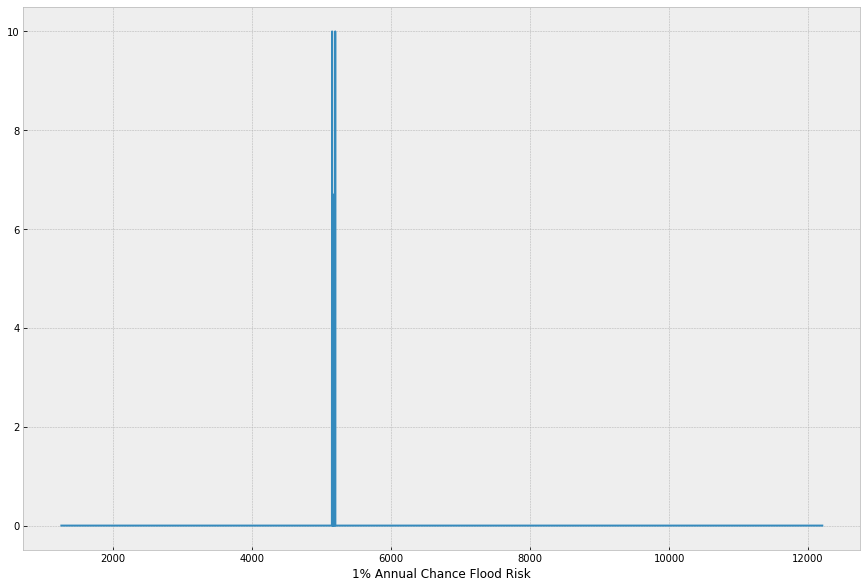

In [124]:
plt.plot(fld_unshuffled.dep_cl)
plt.xlabel("1% Annual Chance Flood Risk")

##1) Random Forest Classifier

Random Forest Classifier
* Objects: Census block groups
* Features:Estimated median income, Percent of population that is not white people, Percent of people below the poverty line, Fraction of people who is not enrolled in school, Estimated total number of children (age under 18), Estimated total number of seniors (age over 65), Water area (where the fraction of the current water area is over 0.05)
* Target: Presence or absence of flood risk (Binary)

In [125]:
# Set feature, target

feat_fld_class = fld_bal_shuffle[['mincome', 'per_nonwhite', 'per_below_povlev', 'no_school_frac', 'under18', 'over65', 'has_water_int']].copy()
targ_fld_class = fld_bal_shuffle["fld_present"].values

feat_tr_fld_class, feat_te_fld_class, targ_tr_fld_class, targ_te_fld_class = train_test_split(feat_fld_class, targ_fld_class, test_size=0.2, random_state=71)


In [126]:
rfc_fld_best = RandomForestClassifier(random_state=314, max_depth=3, max_features=4) #,min_samples_leaf=65)
rfc_fld_best.fit(feat_tr_fld_class, targ_tr_fld_class)

pred_tr_fld_class_best = rfc_fld_best.predict(feat_tr_fld_class)
pred_te_fld_class_best = rfc_fld_best.predict(feat_te_fld_class)

fld_tr_acc_best = accuracy_score(targ_tr_fld_class, pred_tr_fld_class_best)
fld_te_acc_best = accuracy_score(targ_te_fld_class, pred_te_fld_class_best)

print("Final RFC Model (all features) Results: ")
print("Final RFC model (all features) training accuracy: {:.3f}".format(fld_tr_acc_best))
print("Final RFC model (all features) testing accuracy: {:.3f}".format(fld_te_acc_best))

Final RFC Model (all features) Results: 
Final RFC model (all features) training accuracy: 1.000
Final RFC model (all features) testing accuracy: 1.000


In [127]:
importances_fld_class = rfc_fld_best.feature_importances_

imp_fld_class = pd.DataFrame()
imp_fld_class["Feature"] = feat_fld_class.columns
imp_fld_class["Importance"] = importances_fld_class
imp_fld_class =imp_fld_class.sort_values("Importance", ascending=False)

print("Importances for final RFC model (all features):")
print(imp_fld_class)

Importances for final RFC model (all features):
            Feature  Importance
6     has_water_int    0.631702
2  per_below_povlev    0.181157
3    no_school_frac    0.062599
5            over65    0.057428
0           mincome    0.041554
4           under18    0.025560
1      per_nonwhite    0.000000


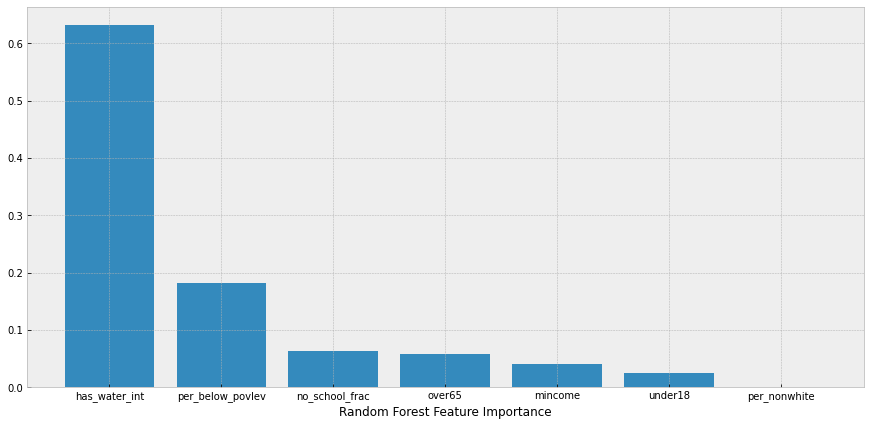

In [128]:
fig, ax = plt.subplots(figsize=[15,7])
ax = plt.bar(imp_fld_class.Feature, imp_fld_class.Importance)
ax = plt.xlabel("Random Forest Feature Importance")

In [129]:
# Feature
feat_fld_class.columns

feat_fld_class_nondemographic = feat_fld_class[['mincome', 'per_nonwhite', 'per_below_povlev', 'no_school_frac', 'under18', 'over65', 'has_water_int']].copy()
#feat_fld_class_nondem = standardize_df(feat_fld_class_nondemographic)
feat_tr_fld_class_nondem, feat_te_fld_class_nondem, targ_tr_fld_class, targ_te_fld_class = train_test_split(feat_fld_class_nondemographic, targ_fld_class, test_size=0.2, random_state=71)

rfc_fld_init_nondem = RandomForestClassifier(random_state=314, max_depth=3, max_features=7) #, min_samples_leaf=90)
rfc_fld_init_nondem.fit(feat_tr_fld_class_nondem, targ_tr_fld_class)

pred_tr_fld_class_nondem = rfc_fld_init_nondem.predict(feat_tr_fld_class_nondem)
pred_te_fld_class_nondem = rfc_fld_init_nondem.predict(feat_te_fld_class_nondem)

fld_tr_acc_init_nondem = accuracy_score(targ_tr_fld_class, pred_tr_fld_class_nondem)
fld_te_acc_init_nondem = accuracy_score(targ_te_fld_class, pred_te_fld_class_nondem)

#feat_fld_class_st = standardize_df(feat_fld_class)
#feat_tr_fld_st, feat_te_fld_st, targ_tr_fld_class, targ_te_fld_class = train_test_split(feat_fld_class_st, targ_fld_class, test_size=0.2, random_state=71)

print("Final RFC Model (without SES features) Results:")
print("Final RFC model training accuracy (without SES features): {:.3f}".format(fld_tr_acc_init_nondem))
print("Final RFC model testing accuracy (without SES features): {:.3f}".format(fld_te_acc_init_nondem))

Final RFC Model (without SES features) Results:
Final RFC model training accuracy (without SES features): 1.000
Final RFC model testing accuracy (without SES features): 1.000


In [130]:
print("RFC Model Comparison:")
print("Percent change in testing accuracy with addition of SES features:" + str(((fld_te_acc_best - fld_te_acc_init_nondem)/fld_te_acc_init_nondem)*100)[:5] + "%")

RFC Model Comparison:
Percent change in testing accuracy with addition of SES features:0.0%


In [131]:
#print("Initial RFC Model (all features) Results:")
#print("Initial RFC model (all features) training accuracy: {:.3f}".format(fld_tr_acc_init))
#print("Initial RFC model (all features) testing accuracy:  {:.3f}".format(fld_te_acc_init))
#print("\n")
print("Final RFC Model (all features) Results: ")
print("Final RFC model (all features) training accuracy: {:.3f}".format(fld_tr_acc_best))
print("Final RFC model (all features) testing accuracy: {:.3f}".format(fld_te_acc_best))
print("\n")
print("Importances for final RFC model (all features):")
print(imp_fld_class)
print("\n")
print("Final RFC Model (without SES features) Results:")
print("Final RFC model training accuracy (without SES features): {:.3f}".format(fld_tr_acc_init_nondem))
print("Final RFC model testing accuracy (without SES features): {:.3f}".format(fld_te_acc_init_nondem))
print("\n")
print("RFC Model Comparison:")
print("Percent change in testing accuracy with addition of SES features:" + str(((fld_te_acc_best - fld_te_acc_init_nondem)/fld_te_acc_init_nondem)*100)[:5] + "%")
print("\n")

Final RFC Model (all features) Results: 
Final RFC model (all features) training accuracy: 1.000
Final RFC model (all features) testing accuracy: 1.000


Importances for final RFC model (all features):
            Feature  Importance
6     has_water_int    0.631702
2  per_below_povlev    0.181157
3    no_school_frac    0.062599
5            over65    0.057428
0           mincome    0.041554
4           under18    0.025560
1      per_nonwhite    0.000000


Final RFC Model (without SES features) Results:
Final RFC model training accuracy (without SES features): 1.000
Final RFC model testing accuracy (without SES features): 1.000


RFC Model Comparison:
Percent change in testing accuracy with addition of SES features:0.0%




##2) Logistic Regression Classification

Logistic Regression
* Objects: Census block groups
* Features:Estimated median income, Percent of population that is not white people, Percent of people below the poverty line, Fraction of people who is not enrolled in school, Estimated total number of children (age under 18), Estimated total number of seniors (age over 65), Water area (where the fraction of the current water area is over 0.05)
* Target: Presence or absence of flood risk (Binary)


In [132]:
# Set feature, target

feat_fld_lrc = fld_bal_shuffle[['mincome', 'per_nonwhite', 'per_below_povlev', 'no_school_frac', 'under18', 'over65', 'has_water_int']].copy()
targ_fld_lrc = fld_bal_shuffle["fld_present"].values

feat_tr_fld, feat_te_fld, targ_tr_fld, targ_te_fld = train_test_split(feat_fld_lrc, targ_fld_lrc, test_size=0.2, random_state=71)


In [133]:
# Logistic regression 
lr_fld = LogisticRegression(random_state=314)
lr_fld.fit(feat_tr_fld, targ_tr_fld_class)

pred_lr_fld_tr = lr_fld.predict(feat_tr_fld)
pred_lr_fld_te = lr_fld.predict(feat_te_fld)

lr_fld_tr_acc_init = accuracy_score(targ_tr_fld_class, pred_lr_fld_tr)
lr_fld_te_acc_init = accuracy_score(targ_te_fld_class, pred_lr_fld_te)

print("Final Logistic Regression (LR) Model (all features) Results:")
print("Final LR model (all features) training accuracy: {:.3f}".format(lr_fld_tr_acc_init))
print("Final LR model (all features) testing accuracy: {:.3f}".format(lr_fld_te_acc_init))

Final Logistic Regression (LR) Model (all features) Results:
Final LR model (all features) training accuracy: 1.000
Final LR model (all features) testing accuracy: 1.000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [134]:
# Coefficient
coefficients_fld_class = lr_fld.coef_[0]
lr_fld_coef= pd.DataFrame()
lr_fld_coef["Feature"] = feat_fld_class.columns
lr_fld_coef["Coefficient"] = coefficients_fld_class
lr_fld_coef["abs"] = lr_fld_coef["Coefficient"].abs()
lr_fld_coef =lr_fld_coef.sort_values("abs", ascending=False)
lr_fld_coef = lr_fld_coef[["Feature", "Coefficient"]]
print(lr_fld_coef)

            Feature  Coefficient
2  per_below_povlev     0.470693
1      per_nonwhite    -0.171088
5            over65    -0.092545
4           under18    -0.046127
6     has_water_int     0.017769
3    no_school_frac    -0.002802
0           mincome     0.000342


In [135]:
print("Final Logistic Regression (LR) Model (all features) Results:")
print("Final LR model (all features) training accuracy: {:.3f}".format(lr_fld_tr_acc_init))
print("Final LR model (all features) testing accuracy: {:.3f}".format(lr_fld_te_acc_init))
print("\n")
print("Coeffecient of Logistic Regression")
print(lr_fld_coef)

Final Logistic Regression (LR) Model (all features) Results:
Final LR model (all features) training accuracy: 1.000
Final LR model (all features) testing accuracy: 1.000


Coeffecient of Logistic Regression
            Feature  Coefficient
2  per_below_povlev     0.470693
1      per_nonwhite    -0.171088
5            over65    -0.092545
4           under18    -0.046127
6     has_water_int     0.017769
3    no_school_frac    -0.002802
0           mincome     0.000342


## 3) Random Forest Regressor

The random forest classifier and the logistic regression classification show the 100% testing and training accuracy. It means it is too easy to be classified. Therefore, the model is needed to be changed to the random forest regressor to make the diversified target variables (not binary).

**Model 1: All Features Included**

* Objects: Census block groups

* Features:Estimated median income, Percent of population that is not white people, Percent of people below the poverty line, Fraction of people who is not enrolled in school, Estimated total number of children (age under 18), Estimated total number of seniors (age over 65), Water area (where the fraction of the current water area is over 0.05)

* Target: 1% annual chance flood risk (coastal flood depth)

**Model 2: Without SED Features**

* Objects: Census block groups

* Features:Estimated median income, Percent of population that is not white people, Percent of people below the poverty line, Fraction of people who is not enrolled in school, Estimated total number of children (age under 18), Estimated total number of seniors (age over 65), Water area (where the fraction of the current water area is over 0.05)

* Target: Target: 1% annual chance flood risk (coastal flood depth)


In [136]:
import seaborn
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [137]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [138]:
# Set feature, target

feat_rfr = fld_bal_shuffle[['mincome', 'per_nonwhite', 'per_below_povlev', 'no_school_frac', 'under18', 'over65', 'has_water_int']].copy()
targ_rfr = fld_bal_shuffle["fld_present"].values

feat_tr_rfr, feat_te_rfr, targ_tr_rfr, targ_te_rfr = train_test_split(feat_rfr, targ_rfr, test_size=0.2, random_state=71)


In [139]:
targ_tr_rfr_var = targ_tr_rfr.var(ddof=0)
targ_te_rfr_var = targ_te_rfr.var(ddof=0)

print("Training data target variance:"+ str(targ_tr_rfr_var)[:5])
print("Testing data target variance:"+ str(targ_te_rfr_var)[:5])

Training data target variance:0.248
Testing data target variance:0.231


In [140]:
# Random Forest Regressor
print("Initial RFR Model Results (all features):")
rfr = RandomForestRegressor(random_state=314, n_estimators=1000)
rfr.fit(feat_tr_rfr, targ_tr_rfr)

pred_tr_rfr_init = rfr.predict(feat_tr_rfr)
pred_te_rfr_init = rfr.predict(feat_te_rfr)

mse_tr_init = mean_squared_error(targ_tr_rfr, pred_tr_rfr_init)
mse_te_init = mean_squared_error(targ_te_rfr, pred_te_rfr_init)
print("Initial model MSE for training data: {:.3f}".format(mse_tr_init))
print("Initial model MSE for testing data: {:.3f}".format(mse_te_init))

mse_var_tr_init = mse_tr_init/targ_tr_rfr_var
mse_var_te_init = mse_te_init/targ_te_rfr_var
print("Initial model MSE/var for training data: {:.3f}".format(mse_var_tr_init))
print("Initial model MSE/var for testing data: {:.3f}".format(mse_var_te_init))

Initial RFR Model Results (all features):
Initial model MSE for training data: 0.000
Initial model MSE for testing data: 0.000
Initial model MSE/var for training data: 0.000
Initial model MSE/var for testing data: 0.000


In [141]:
# Random Forest Regressor - adjust the model
print("Final RFR Model Results (all features)")
rfr_best = RandomForestRegressor(random_state=302, max_depth=3, min_samples_leaf=10, max_features=2)
rfr_best.fit(feat_tr_rfr, targ_tr_rfr)

pred_tr_rfr_best = rfr_best.predict(feat_tr_rfr)
pred_te_rfr_best = rfr_best.predict(feat_te_rfr)

mse_tr_best = mean_squared_error(targ_tr_rfr, pred_tr_rfr_best)
mse_te_best = mean_squared_error(targ_te_rfr, pred_te_rfr_best)
print("Final model (all features) MSE for training data: {:.3f}".format(mse_tr_best))
print("Final model (all features) MSE for testing data: {:.3f}".format(mse_te_best))

mse_var_tr_best = mse_tr_best/targ_tr_rfr_var
mse_var_te_best = mse_te_best/targ_te_rfr_var
print("Final model (all features) MSE/var for training data: {:.3f}".format(mse_var_tr_best))
print("Final model (all features) MSE/var for testing data:  {:.3f}".format(mse_var_tr_best))

Final RFR Model Results (all features)
Final model (all features) MSE for training data: 0.051
Final model (all features) MSE for testing data: 0.049
Final model (all features) MSE/var for training data: 0.206
Final model (all features) MSE/var for testing data:  0.206


In [142]:
print("mean sq error of the model on training data {:.2f} ({:.0f}%)".format(mse_tr_best, mse_tr_best * 100))
print("mean sq error of the model on test data {:.2f} ({:.0f}%)".format(mse_var_tr_best, mse_var_tr_best * 100))

mean sq error of the model on training data 0.05 (5%)
mean sq error of the model on test data 0.21 (21%)


In [143]:
# importances
rfr_te_best_r2 = rfr_best.score(feat_te_rfr, targ_te_rfr)
print("Final model (all features) coefficient of determination (R^2): {:.3f}".format(rfr_te_best_r2))

importances = rfr_best.feature_importances_
imp_rfr = pd.DataFrame()
imp_rfr["Feature"] = feat_tr_rfr.columns
imp_rfr["Importance"] = importances
imp_rfr =imp_rfr.sort_values("Importance", ascending=False)
print("\n")
print(imp_rfr)

Final model (all features) coefficient of determination (R^2): 0.789


            Feature  Importance
2  per_below_povlev    0.272727
6     has_water_int    0.272727
3    no_school_frac    0.202020
5            over65    0.080808
1      per_nonwhite    0.070707
0           mincome    0.060606
4           under18    0.040404


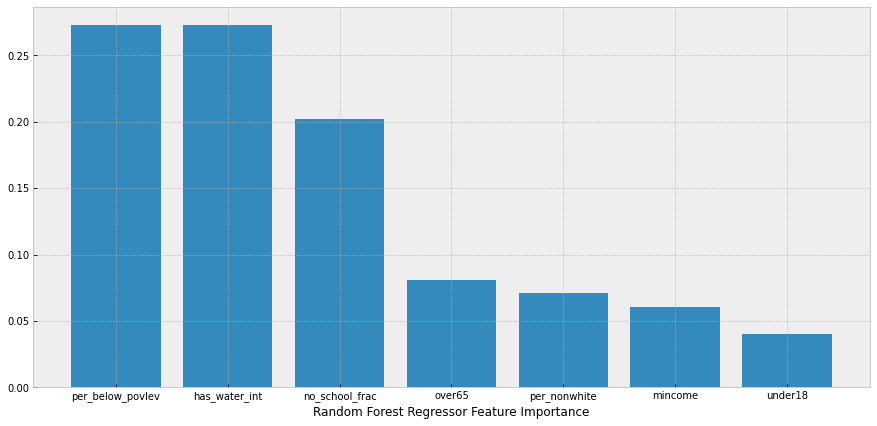

In [144]:
importances = rfr_best.feature_importances_

imp_rfr = pd.DataFrame()
imp_rfr["Feature"] = feat_rfr.columns
imp_rfr["Importance"] = importances
imp_rfr =imp_rfr.sort_values("Importance", ascending=False)

fig, ax = plt.subplots(figsize=[15,7])
ax = plt.bar(imp_rfr.Feature, imp_rfr.Importance)
ax = plt.xlabel("Random Forest Regressor Feature Importance")